In [986]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [987]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u, constants as const
import sys
sys.path.append('/home/gusinskaia/screens')
#from screens.fields import dynamic_field, theta_grid
from screens.fields import dynamic_field


In [988]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [989]:
from glob import glob
import os, math, time
from astropy.time import Time
from astropy.visualization import quantity_support#, time_support
from astropy import constants as const

import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth
import wsrt_fits as wf

quantity_support()
plt.rcParams['figure.dpi'] = 50

In [990]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
nsdir=trdir+'dss_wsrt_wnoise/'
list_obs=sorted(glob(nsdir+'*wns.npz'))
print (len(list_obs))

214


In [991]:
def plot_hex(mjd,vel, size=40,colorbar=True, vmin=None, vmax=None, cmap='seismic', fclr='w'):
    pb_i =1.6293932
    #pb_o = par_dict['pb_o']
    plt.set_cmap(cmap)
    ax=plt.subplot()
    ax.set_facecolor(fclr)
    im=plt.hexbin(mjd,(mjd/pb_i)%1,vel,size,linewidths=0.1, vmin=vmin, vmax=vmax) 
    plt.ylabel("inner phase")
    plt.xlabel("MJD")
    if colorbar:
        cb = plt.colorbar(im)
        cb.set_label('veff/deff^0.5')
    return
mjd_year = 55197
year_mjd = 2010
def day_to_year(mjd):
    return (mjd-mjd_year)/365.2425+year_mjd

In [992]:
def plot_folded(mjds,pars, pars_err,ylab=r'v$_{eff}$ / d$_{eff}$ $^{0.5}$  (mean)', mjd_ref=None, new_fig=True,
               scatter=False, color='grey', ms=6):
    if new_fig is True:
        plt.figure(figsize=(5,3), dpi=150)
    Pb_d=1.6293932
    if mjd_ref is None:
        mjd_ref=np.amin(mjds)
    phase_folded_unq=np.mod((mjds-mjd_ref),Pb_d)
    plt.errorbar(phase_folded_unq/Pb_d,pars, yerr=np.array(pars_err), color=color, ls='None', marker='o', ms=ms)
    if scatter is True:
        plt.scatter(phase_folded_unq/Pb_d,pars, c=pars, zorder=2)
    plt.ylabel(ylab)
    plt.xlabel('Phase of the inner orbit')

In [999]:
import pickle
#list_pickles=sorted(glob('long_obs_fit_results/*wnz_nored*.pickle'))
list_pickles=sorted(glob('filtered_fit/*nodof*.pickle'))
print (len(list_pickles))

dv_ind_all,dv_ind_all_err, dv_ovl_all,dv_ovl_all_err=[],[],[],[]
dv_ind_sim,dv_ind_sim_err, dv_ovl_sim,dv_ovl_sim_err=[],[],[],[]
mjds_dvs=[]
for i in range(0,len(list_pickles)):
    res_pickle=pickle.load(open(list_pickles[i], 'rb'))
    
    
    
    dv_ind, dv_err_ind, fr_ind=[],[],[]
    dv_ovl, dv_err_ovl,  fr_ovl=[],[],[]
    for i in range(0,len(res_pickle['res_ind'][0])):
        dv_ind.append(res_pickle['res_ind'][0][i]['dveff'].value)
        dv_err_ind.append(res_pickle['res_ind'][0][i]['dveff_err'].value)
        fr_ind.append(res_pickle['res_ind'][0][i]['mean_f'].value)
    for i in range(0,len(res_pickle['res_ovlp_'][0])):   
        dv_ovl.append(res_pickle['res_ovlp_'][0][i]['dveff'].value)
        dv_err_ovl.append(res_pickle['res_ovlp_'][0][i]['dveff_err'].value)
        fr_ovl.append(res_pickle['res_ovlp_'][0][i]['mean_f'].value)
    
    dv_ind_all.append(np.mean(dv_ind))
    dv_ind_all_err.append(np.std(dv_ind))
    dv_ovl_all.append(np.mean(dv_ovl))
    dv_ovl_all_err.append(np.std(dv_ovl))
    dv_ind_sim.append(res_pickle['res_ind_sim'][0].value)
    dv_ind_sim_err.append(res_pickle['res_ind_sim'][1].value)
    dv_ovl_sim.append(res_pickle['res_ovlp_sim'][0].value)
    dv_ovl_sim_err.append(res_pickle['res_ovlp_sim'][1].value)
    mjds_dvs.append(res_pickle['res_ovlp_'][0][0]['mean_t'])

249


In [1092]:
import pickle
#list_pickles=sorted(glob('long_obs_fit_results/*wnz_nored*.pickle'))
#list_pickles=sorted(glob('fit_res_bottom_parabola/*.pickle'))
list_pickles=sorted(glob('res_ed05*parabola*.pickle'))
print (len(list_pickles))

dv_ind_all,dv_ind_all_err, dv_ovl_all,dv_ovl_all_err=[],[],[],[]
dv_ind_sim,dv_ind_sim_err, dv_ovl_sim,dv_ovl_sim_err=[],[],[],[]
mjds_dvs=[]
for i in range(0,len(list_pickles)):
    res_pickle=pickle.load(open(list_pickles[i], 'rb'))
    
    dv_ovl, dv_err_ovl,  fr_ovl=[],[],[]

    for k in range(0,len(res_pickle['res_ovlp_'][0])):   
        dv_ovl.append(res_pickle['res_ovlp_'][0][k]['dveff'].value)
        dv_err_ovl.append(res_pickle['res_ovlp_'][0][k]['dveff_err'].value)
        fr_ovl.append(res_pickle['res_ovlp_'][0][k]['mean_f'].value)
    
    dv_ovl_all.append(np.mean(dv_ovl))
    dv_ovl_all_err.append(np.std(dv_ovl))
    dv_ovl_sim.append(res_pickle['res_ovlp_sim'][0].value)
    dv_ovl_sim_err.append(res_pickle['res_ovlp_sim'][1].value)
    mjds_dvs.append(res_pickle['res_ovlp_'][0][0]['mean_t'])

255


In [1074]:
mjds_dvs[-1]

56409.59114577712

In [1094]:
import pickle
#list_pickles=sorted(glob('long_obs_fit_results/*wnz_nored*.pickle'))
list_pickles=sorted(glob('res_ed025*.pickle'))
#list_pickles=sorted(glob('*.pickle'))
print (len(list_pickles))

dv_ind_all,dv_ind_all_err, dv_ovl_all,dv_ovl_all_err=[],[],[],[]
dv_ind_sim,dv_ind_sim_err, dv_ovl_sim,dv_ovl_sim_err=[],[],[],[]
mjds_dvs=[]
for i in range(0,len(list_pickles)):
    res_pickle=pickle.load(open(list_pickles[i], 'rb'))
    
    dv_ovl, dv_err_ovl,  fr_ovl=[],[],[]

    for k in range(0,len(res_pickle['res_ovlp_'][0])):   
        dv_ovl.append(res_pickle['res_ovlp_'][0][k]['dveff'].value)
        dv_err_ovl.append(res_pickle['res_ovlp_'][0][k]['dveff_err'].value)
        fr_ovl.append(res_pickle['res_ovlp_'][0][k]['mean_f'].value)
    
    dv_ovl_all.append(np.mean(dv_ovl))
    dv_ovl_all_err.append(np.std(dv_ovl))
    dv_ovl_sim.append(res_pickle['res_ovlp_sim'][0].value)
    dv_ovl_sim_err.append(res_pickle['res_ovlp_sim'][1].value)
    mjds_dvs.append(res_pickle['res_ovlp_'][0][0]['mean_t'])

253


In [1095]:
dv_ovl_all_bot025,dv_ovl_all_bot025_err=dv_ovl_all,dv_ovl_all_err
dv_ovl_sim_bot025,dv_ovl_sim_bot025_err=dv_ovl_sim,dv_ovl_sim_err
#dv_ind_sim_all,dv_ind_sim_all_err=dv_ind_sim,dv_ind_sim_err
mjds_dvs_bot025=mjds_dvs

In [984]:
100/(0.25/0.02)

8.0

In [970]:
(10*u.l/2*u.ml).decompose

<bound method Quantity.decompose of <Quantity 5. l ml>>

In [1093]:
dv_ovl_all_bot,dv_ovl_all_bot_err=dv_ovl_all,dv_ovl_all_err
dv_ovl_sim_bot,dv_ovl_sim_bot_err=dv_ovl_sim,dv_ovl_sim_err
#dv_ind_sim_all,dv_ind_sim_all_err=dv_ind_sim,dv_ind_sim_err
mjds_dvs_bot=mjds_dvs

In [1000]:
dv_ovl_all_all,dv_ovl_all_all_err=dv_ovl_all,dv_ovl_all_err
dv_ovl_sim_all,dv_ovl_sim_all_err=dv_ovl_sim,dv_ovl_sim_err
dv_ind_sim_all,dv_ind_sim_all_err=dv_ind_sim,dv_ind_sim_err
mjds_dvs_all=mjds_dvs

Text(0, 0.5, 'veff/deff^0.5')

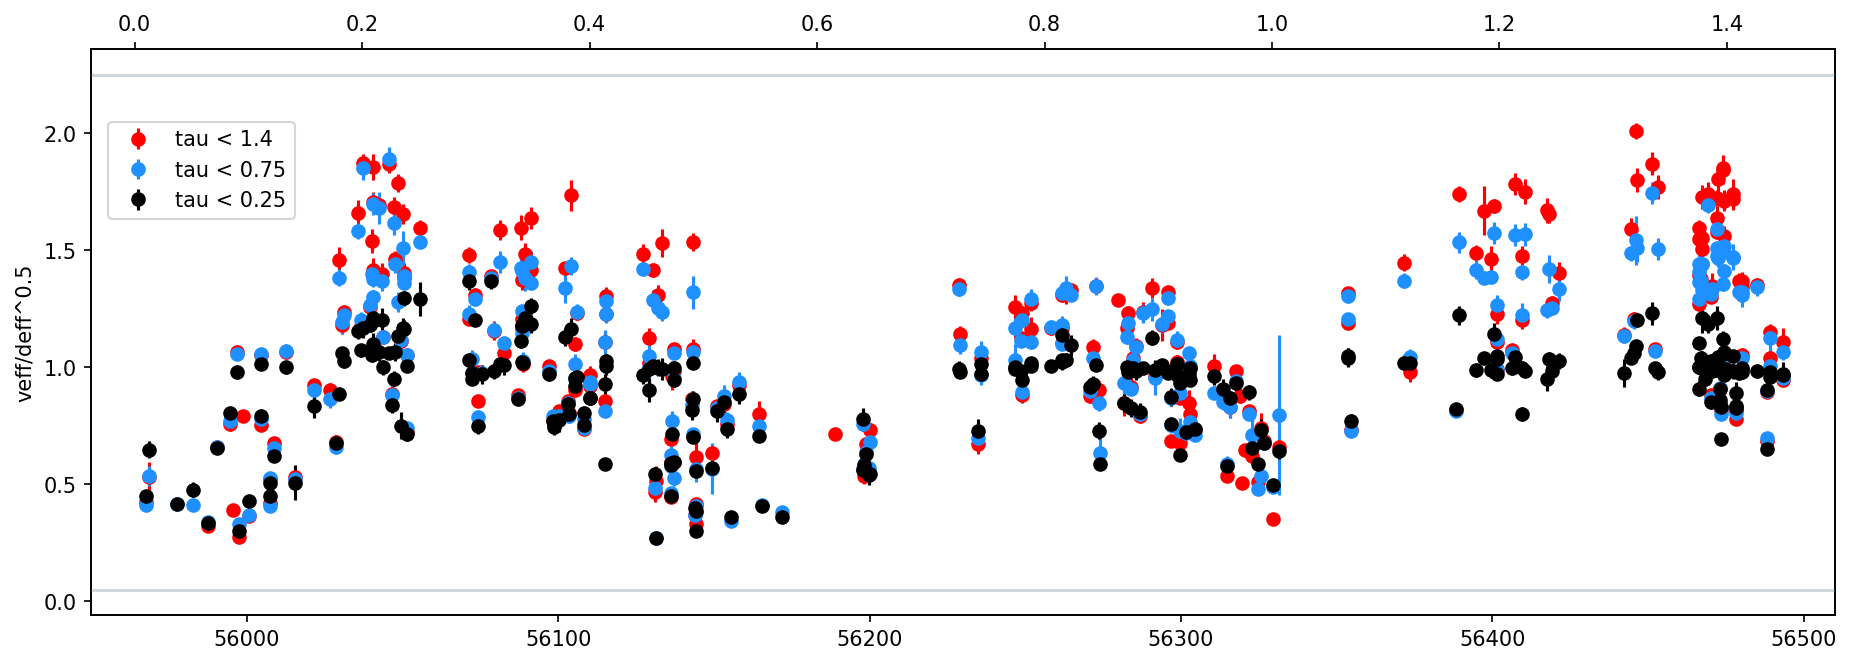

In [1096]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
#ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
#             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', label='tau < 1.4')



#ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_all_bot,yerr=dv_ovl_all_bot_err, color='c', marker='o',
#             ls='none')
ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_sim_bot,yerr=dv_ovl_sim_bot_err, color='dodgerblue', marker='o',
             ls='none', label='tau < 0.75')

ax1.errorbar(np.array(mjds_dvs_bot025),dv_ovl_sim_bot025,yerr=dv_ovl_sim_bot025_err, color='k', marker='o',
             ls='none', label='tau < 0.25')

plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)


ax1.legend(loc=(0.01,0.7))
ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax1.set_ylabel('veff/deff^0.5')

In [1103]:
dveff_unit=res_pickle['res_ovlp_'][0][k]['dveff'].unit

<Time object: scale='utc' format='mjd' value=[55967.72094912 55968.71747689 55977.72019678 55982.84965279
 55987.65729169 55990.58755787 55994.71574077 55996.84606484
 55997.64803242 56000.77627317 56004.45717592 56004.58530095
 56007.46631947 56007.50098382 56008.65445603 56012.6721065
 56015.51869213 56021.65300929 56026.6775463  56028.66307874
 56029.54745372 56030.7158565  56031.36469911 56035.61493056
 56036.64328706 56037.34317132 56039.61168985 56040.34097225
 56040.4359954  56040.52395835 56040.66481484 56042.45509263
 56043.57633106 56043.68449079 56045.67766206 56046.68668983
 56047.35717595 56047.49421298 56048.65636577 56049.64942131
 56050.31458337 56050.45983798 56050.58501159 56051.49855325
 56051.58177087 56055.66342595 56071.25353013 56071.3367477
 56072.26116901 56072.36521991 56073.44884261 56074.25578704
 56075.47245374 56078.31956019 56079.32650467 56081.33692133
 56082.51770833 56087.23055558 56088.20717596 56088.29039355
 56088.38026625 56088.46348384 56088.58101

In [ ]:
data = pickle.load( open('data_all_all.pickle', 'rb'))

t = data['t']
dveff_obs = data['dv_eff']
dveff_err = data['dv_eff_err']

In [1109]:

import pickle
#ttt=Time(np.array(mjds_dvs_bot),format='mjd')

data = {
    'dv_eff': np.array(dv_ovl_all_bot)*dveff_unit,
    'dv_eff_err': np.array(dv_ovl_all_bot_err)*dveff_unit,
    't': np.array(mjds_dvs_bot)
}

with open('data_all_all_bot0.75.pickle', 'wb') as e:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, e, pickle.HIGHEST_PROTOCOL)

No handles with labels found to put in legend.


Text(0, 0.5, 'veff/deff^0.5')

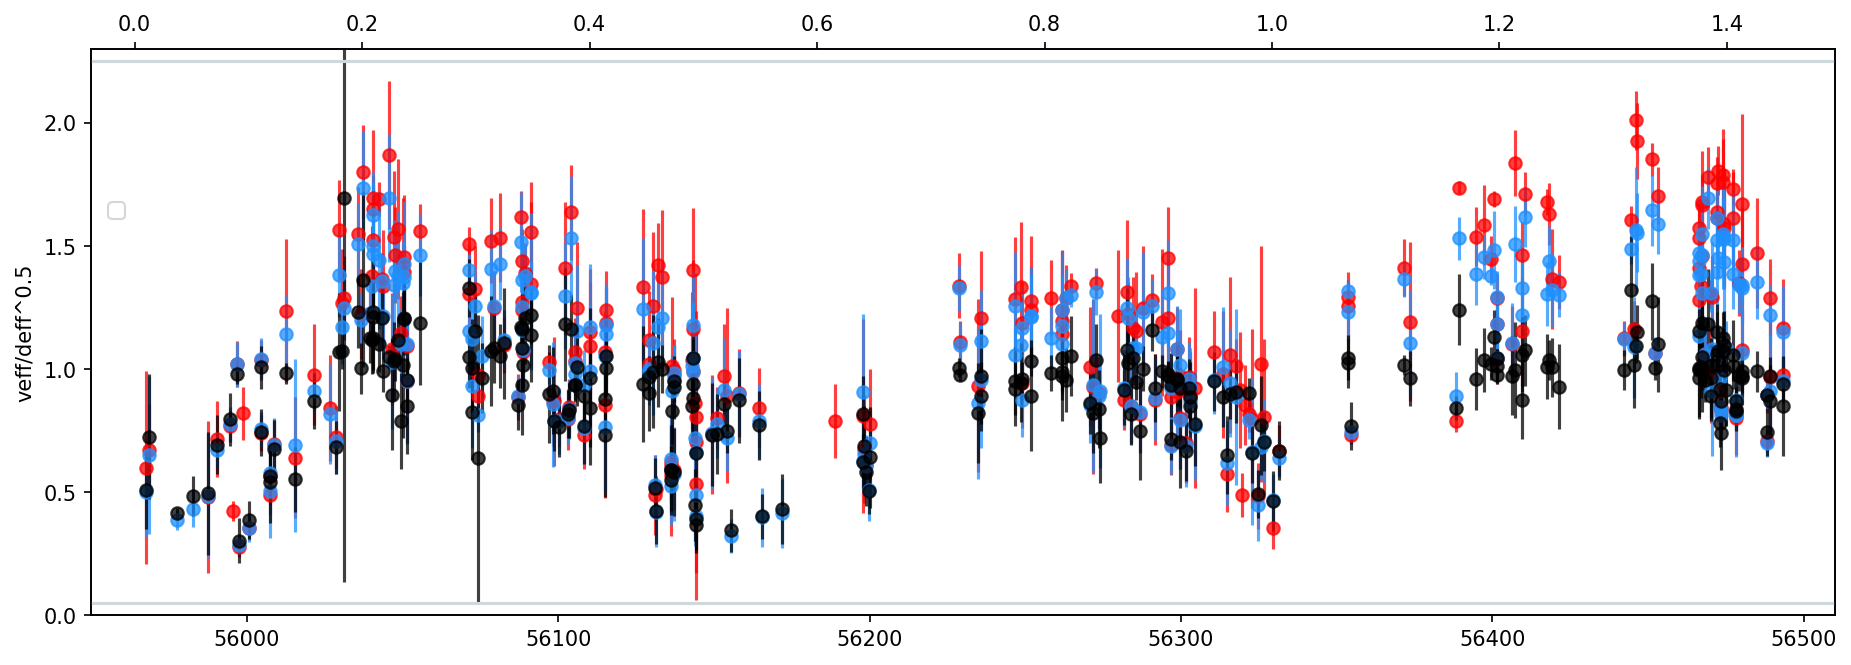

In [1099]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='r', marker='o',
             ls='none', alpha=0.75)
#ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
#             ls='none', label='tau < 1.4')



ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_all_bot,yerr=dv_ovl_all_bot_err, color='dodgerblue', marker='o',
                          ls='none', alpha=0.75)
#ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_sim_bot,yerr=dv_ovl_sim_bot_err, color='dodgerblue', marker='o',
#             ls='none', label='tau < 0.75')

#ax1.errorbar(np.array(mjds_dvs_bot025),dv_ovl_sim_bot025,yerr=dv_ovl_sim_bot025_err, color='k', marker='o',
#             ls='none', label='tau < 0.25')
ax1.errorbar(np.array(mjds_dvs_bot025),dv_ovl_all_bot025,yerr=dv_ovl_all_bot025_err, color='k', marker='o',
                          ls='none', alpha=0.75)

plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)

ax1.set_ylim(0.0,2.3)
ax1.legend(loc=(0.01,0.7))
ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax1.set_ylabel('veff/deff^0.5')

Text(0, 0.5, 'veff/deff^0.5')

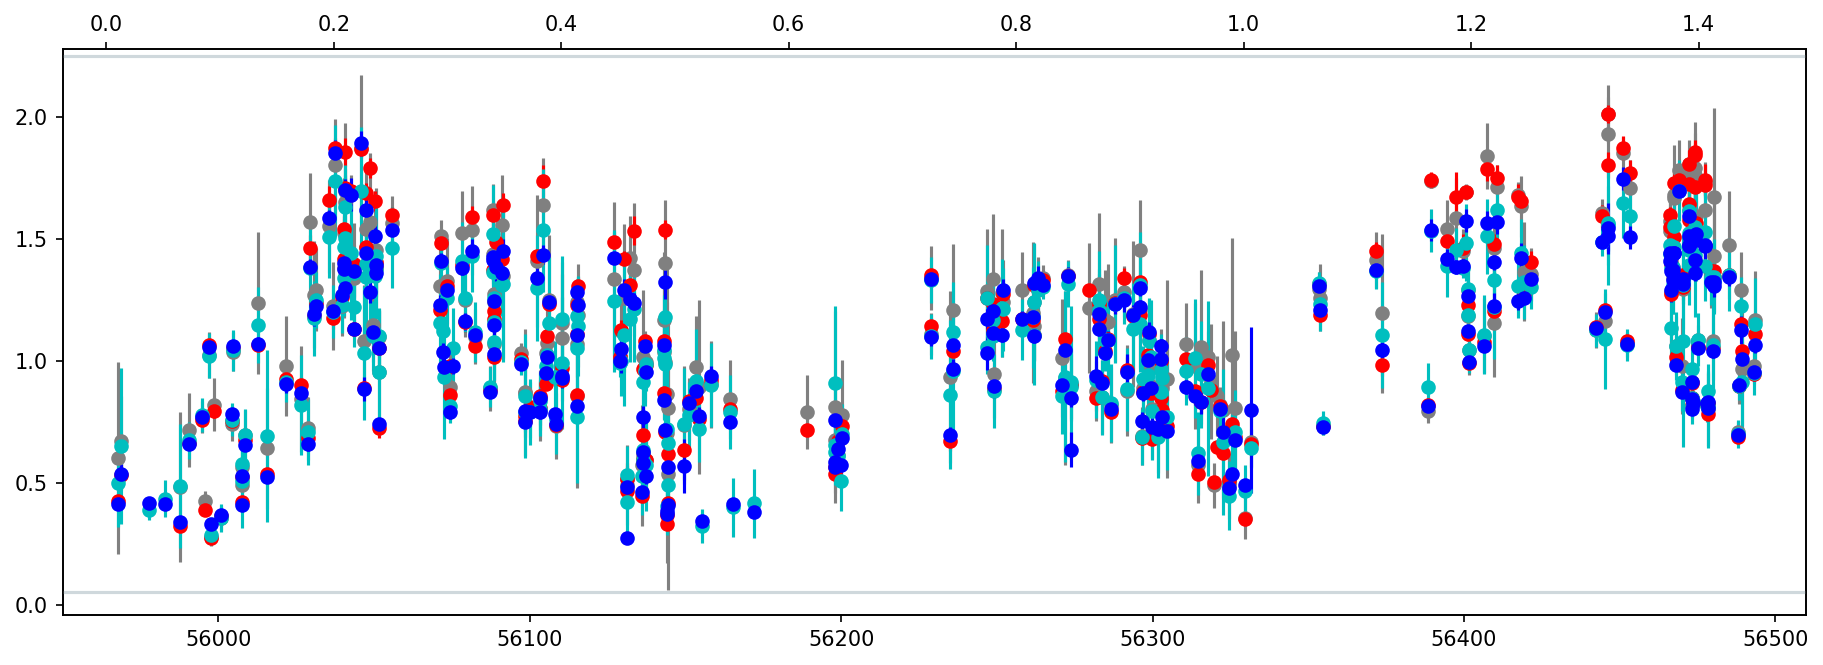

In [1100]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none')



ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_all_bot,yerr=dv_ovl_all_bot_err, color='c', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_bot),dv_ovl_sim_bot,yerr=dv_ovl_sim_bot_err, color='b', marker='o',
             ls='none')

plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)

ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
plt.ylabel('veff/deff^0.5')

#ax2.set_xlim(day_to_year(d_n), day_to_year(d_x))

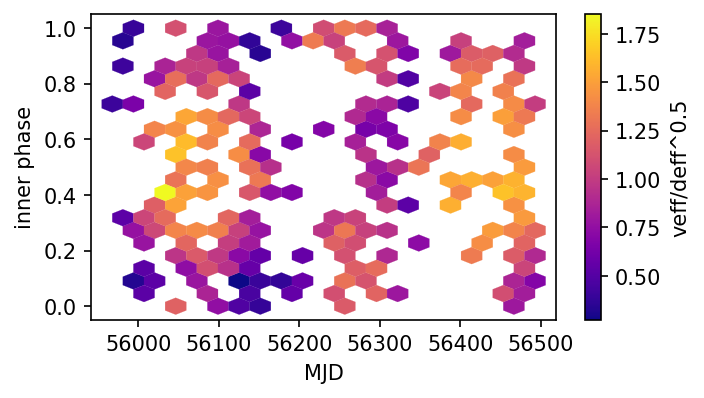

In [1101]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_bot)-0.18,np.array(dv_ovl_sim_bot), size=20,cmap='plasma')
         #fclr=np.array([207, 216, 220])/255.)#, vmin=0.5,vmax=1.5)

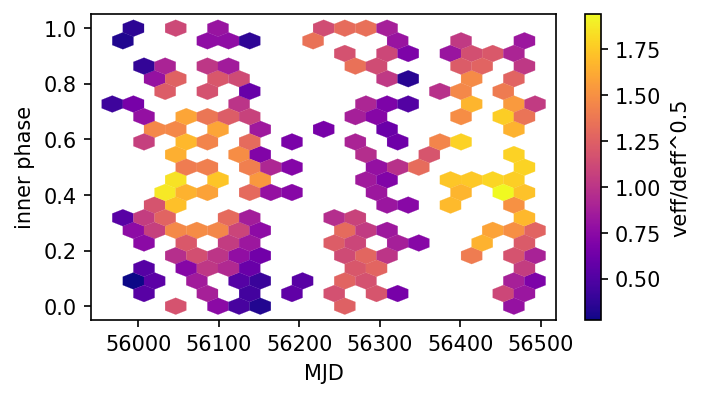

In [686]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,np.array(dv_ovl_sim_all), size=20,cmap='plasma')
         #fclr=np.array([207, 216, 220])/255.)#, vmin=0.5,vmax=1.5)

In [687]:
from astropy.coordinates import EarthLocation, SkyOffsetFrame, SkyCoord

In [838]:
PB_i=1.6293932*u.day
PB_o=327.25685*u.day
a_i=1.92379*const.c.to('cm/s').value
a_o=117.992*const.c.to('cm/s').value
e_i=6.9e-4
e_o=3.5e-2
omg_i=97.5638*u.deg
omg_o=95.6212*u.deg
i_ang=39.263*u.deg
T_asc0_i=Time(55920.40771662, format='mjd')
T_asc0_o=Time(56233.93512, format='mjd')
dp=1136*u.pc

asini_i=1.2175252*u.s*const.c
asini_o=74.672629*u.s*const.c



orb_par_i={'Pb':PB_i, 'a':a_i, 'e':e_i,'omg':omg_i, 'i':i_ang, 'Tasc0':T_asc0_i}
orb_par_o={'Pb':PB_o, 'a':a_o, 'e':e_o,'omg':omg_o, 'i':i_ang, 'Tasc0':T_asc0_o}

In [815]:
#wsrt_loc=EarthLocation.from_geodetic('6d36m7.19s','52d54m31.79s')
wsrt_loc=EarthLocation('6d36m7.19s','52d54m31.79s')
#wsrt_loc.geodetic

coords = SkyCoord('03 37 43.82589 +17 15 14.8280', unit=(u.hourangle, u.deg))

psr = SkyCoord(ra=coords.ra, dec=coords.dec,
               pm_ra_cosdec=5.90*u.mas/u.yr, pm_dec=-4.02*u.mas/u.yr,
               distance=1300*u.pc)

psr_frame = SkyOffsetFrame(origin=psr)

hh=psr.pm_ra_cosdec.to('mas/yr')
hh

<Quantity 5.9 mas / yr>

In [816]:
def orb_mean_vel(asini, pb):
    k=2.*math.pi*asini/pb
    return k

def phase_orbit(t,T0,pb):
    th_p = ((t - T0) / pb).to('') * u.cycle
    return th_p
  
def earth_vel(t, psr_frame, tel_loc):
    pos = tel_loc.get_gcrs(t).transform_to(psr_frame).cartesian
    vel = pos.differentials['s']
    return vel.d_xyz.to(u.km / u.s)

def mu_to_vel(mu,distance):
    mu=mu.to('mas/yr').value
    d=distance.to(u.pc).value
    vel=(mu*4.74*d*1e-3)*u.km/u.s
    return vel
    

In [817]:
360-44-90

226

In [930]:
s=0.875
ds=(1-s)*dp
D_eff=dp*ds/(dp-ds)

Omg_s=131.157*u.deg

Omg_p=-44.56*u.deg#(360-44-90)*u.deg# from Voisin et al. 2020
dOmg_p=Omg_s-Omg_p

bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

bse = np.sin(Omg_s) / (D_eff**0.5)
bce = np.cos(Omg_s) / (D_eff**0.5)

v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

V_ism=7.875*u.km/u.s

dveff_c = (V_ism/s - (v_pm_ra*np.sin(Omg_s) + v_pm_dec*np.cos(Omg_s)))/D_eff**0.5
#dveff_c = - 0.4*u.km/u.s/u.pc**0.5

print (bsp,bcp,bse,bce,dveff_c)

-0.017669538647266482 1 / pc(1/2) -0.0010245692922566238 1 / pc(1/2) 0.059102025468954246 1 / pc(1/2) -0.05166161453587181 1 / pc(1/2) 0.27849621985640133 km / (pc(1/2) s)


In [937]:
s=0.71
ds=(1-s)*dp
D_eff=dp*ds/(dp-ds)

Omg_s=58.381*u.deg

Omg_p=-157.834*u.deg#(360-44-90)*u.deg# from Voisin et al. 2020
dOmg_p=Omg_s-Omg_p

bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

bse = np.sin(Omg_s) / (D_eff**0.5)
bce = np.cos(Omg_s) / (D_eff**0.5)

v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

V_ism=8.674*u.km/u.s

dveff_c = (V_ism/s - (v_pm_ra*np.sin(Omg_s) + v_pm_dec*np.cos(Omg_s)))/D_eff**0.5
#dveff_c = - 0.4*u.km/u.s/u.pc**0.5

print (bsp,bcp,bse,bce,dveff_c)

-0.024172831709118985 1 / pc(1/2) 0.013705415216242774 1 / pc(1/2) 0.039532361473905396 1 / pc(1/2) 0.02433854576776483 1 / pc(1/2) 0.26936211245468267 km / (pc(1/2) s)


In [938]:
t=Time(np.array(mjds_dvs_all), format='mjd')

#t=np.arange(mjds_dvs_all[0],mjds_dvs_all[-1], 0.25)
#t=Time(t, format='mjd')


Kp_i=orb_mean_vel(asini_i, PB_i)
Kp_o=orb_mean_vel(asini_o, PB_o)

ph_i=phase_orbit(t, T_asc0_i, PB_i)
ph_o=phase_orbit(t, T_asc0_o, PB_o)

Ve=earth_vel(t, psr_frame, wsrt_loc)
Ve_ra=Ve[1]
Ve_dec=Ve[2]


dveff_model = (bsp * (Kp_i * np.sin(ph_i) + Kp_o * np.sin(ph_o))
             + bcp * (Kp_i * np.cos(ph_i) + Kp_o * np.cos(ph_o))
             - Ve_ra * bse - Ve_dec * bce + dveff_c)
               

In [939]:
earth_motion=- Ve_ra * bse - Ve_dec * bce + dveff_c

In [940]:
model=dveff_model.to(u.km/u.s/u.pc**0.5).value
model_abs=np.abs(dveff_model.to(u.km/u.s/u.pc**0.5).value)

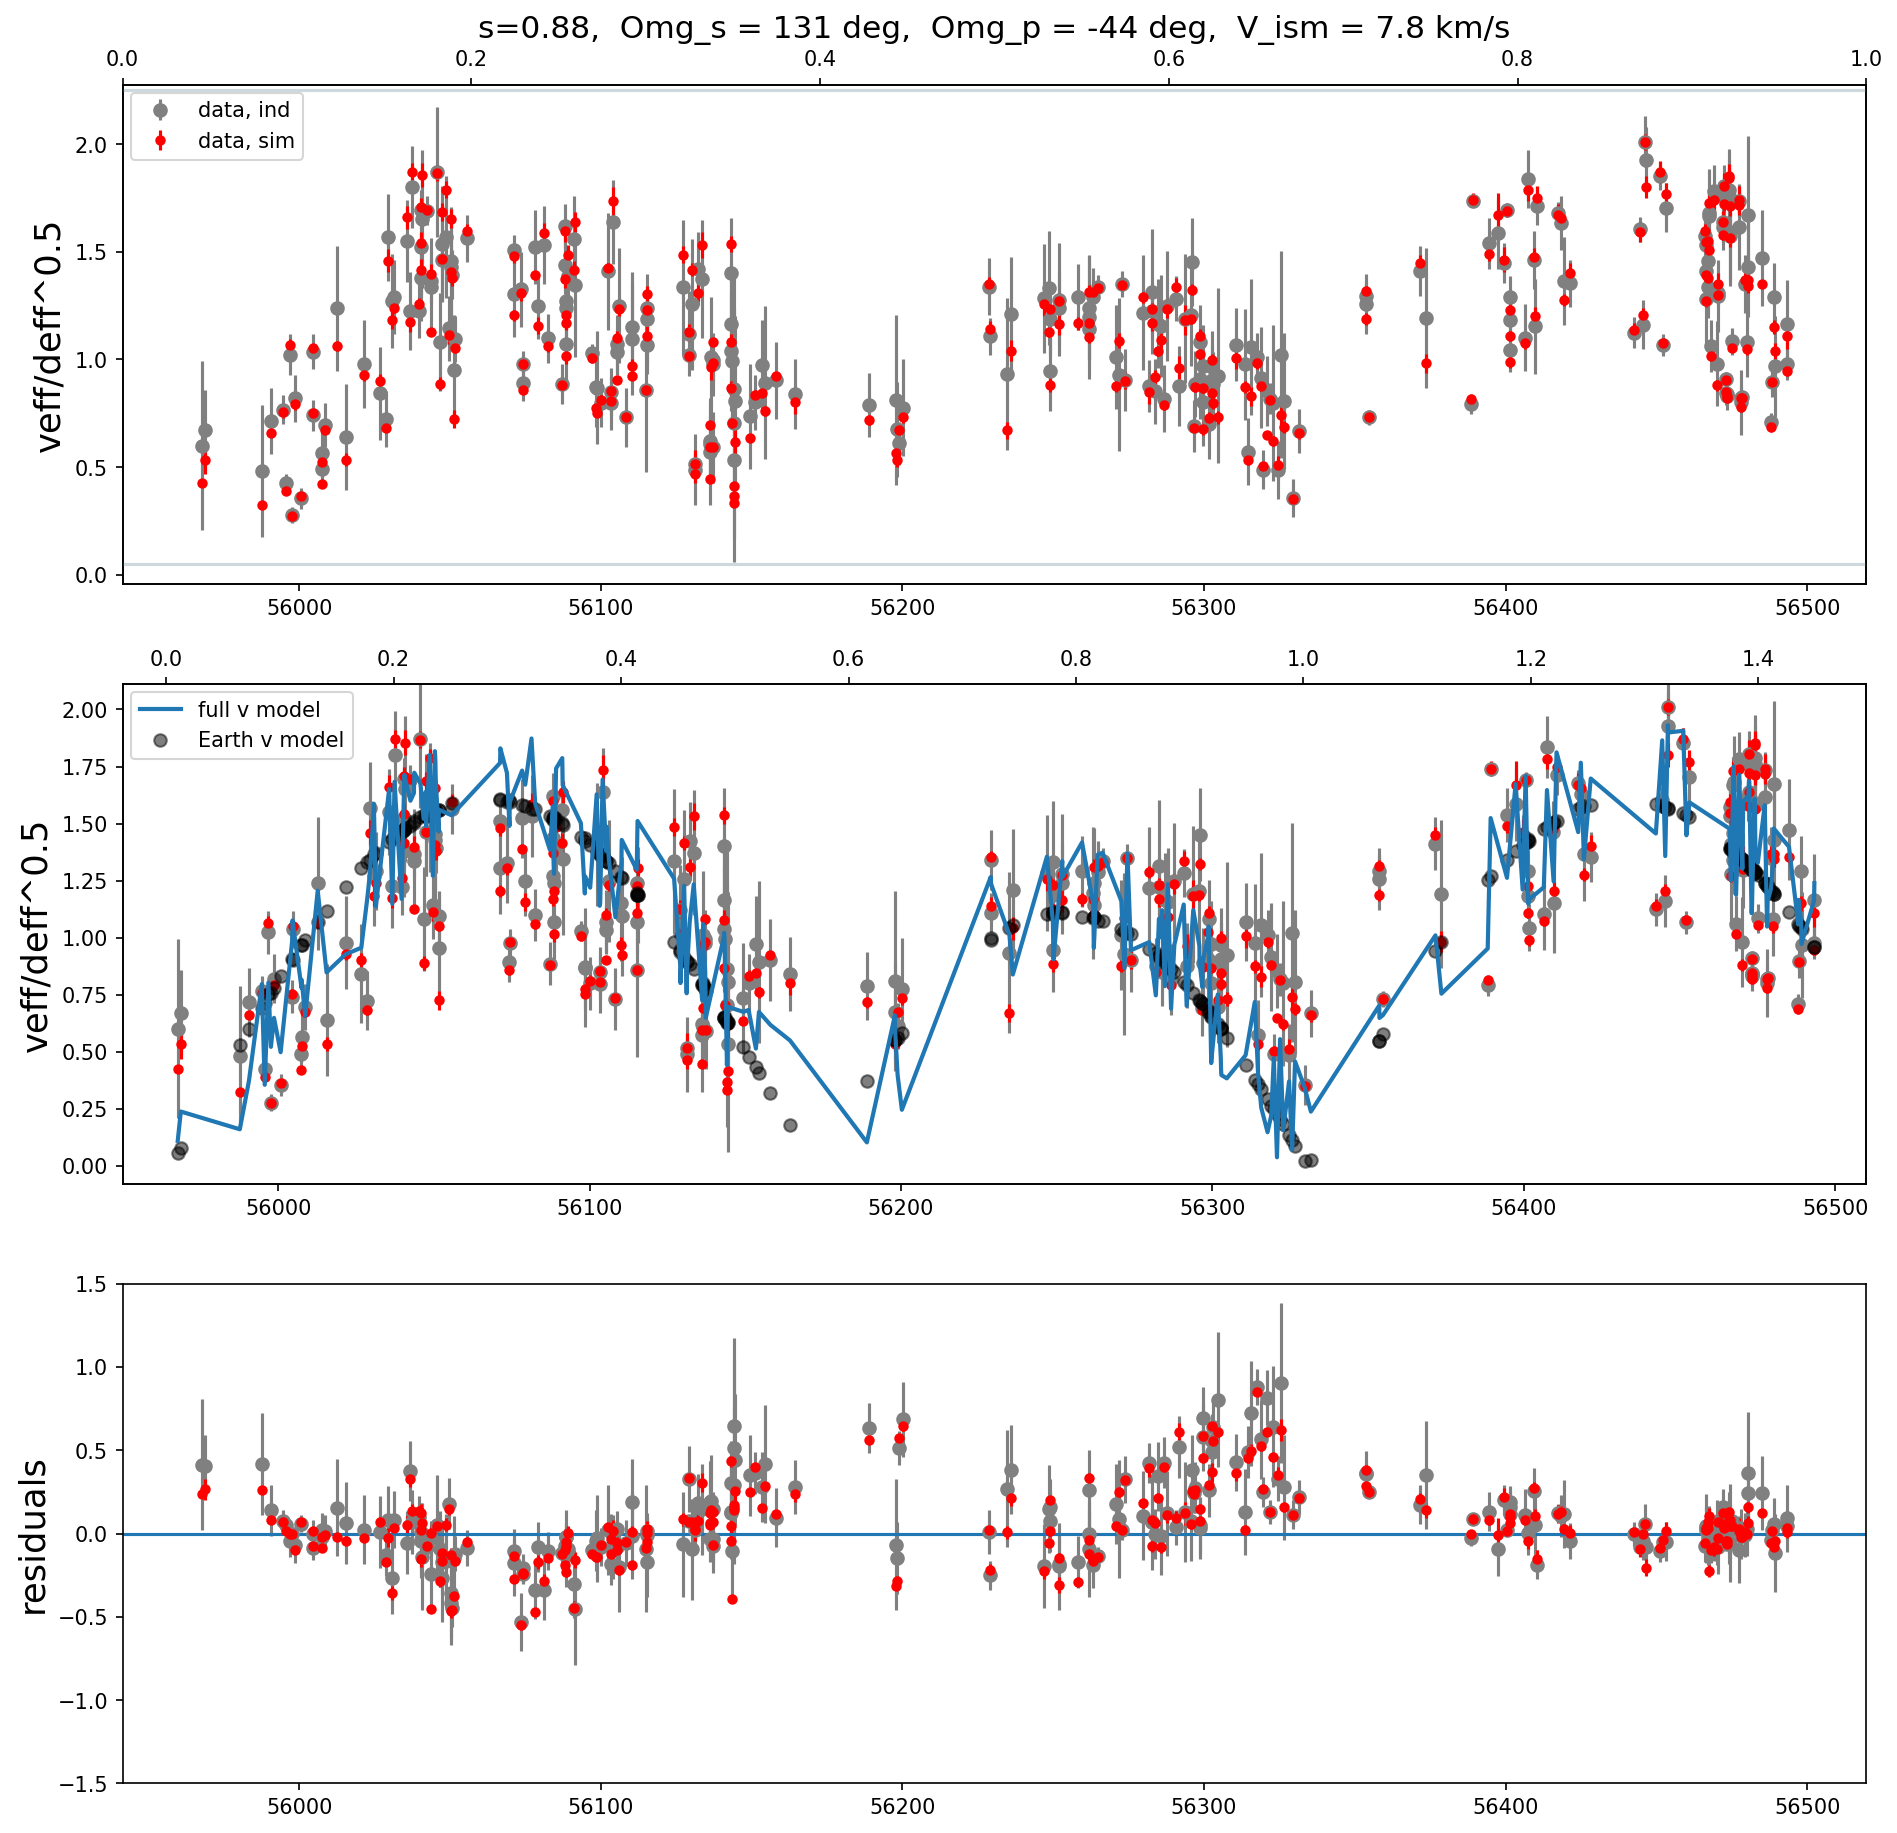

In [934]:
fig, ax1 = plt.subplots(figsize=(15,15), dpi=150)
ax1=plt.subplot(311)
ax2 = ax1.twiny()
ax1.set_title('s=0.88,  Omg_s = 131 deg,  Omg_p = -44 deg,  V_ism = 7.8 km/s', fontsize=15)
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none', label='data, ind')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4, label='data, sim')
plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)
ax1.set_ylabel('veff/deff^0.5', fontsize=17)

ax1.legend(loc=(0.005,0.85))

#fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)

ax1=plt.subplot(312)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4)

ax1.errorbar(np.array(mjds_dvs_all),np.abs(earth_motion), color='k', marker='o',
             ls='none', lw=3, alpha=0.5, label='Earth v model')
ax1.plot(t.mjd, model_abs, lw=2, zorder=3, label='full v model')
ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax1.set_ylabel('veff/deff^0.5', fontsize=17)
ax1.legend(loc=(0.005,0.85))

ax1=plt.subplot(313)
residuals_all_omgpfx=np.array(dv_ovl_all_all)-model_abs
residuals_sim_omgpfx=np.array(dv_ovl_sim_all)-model_abs
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.axhline(0.0)
ax1.set_ylim(-1.5,1.5)
ax1.set_ylabel('residuals', fontsize=17)
plt.savefig('fit_try_Omg_p_fixed.png',format='png',bbox_inches='tight',dpi=100)

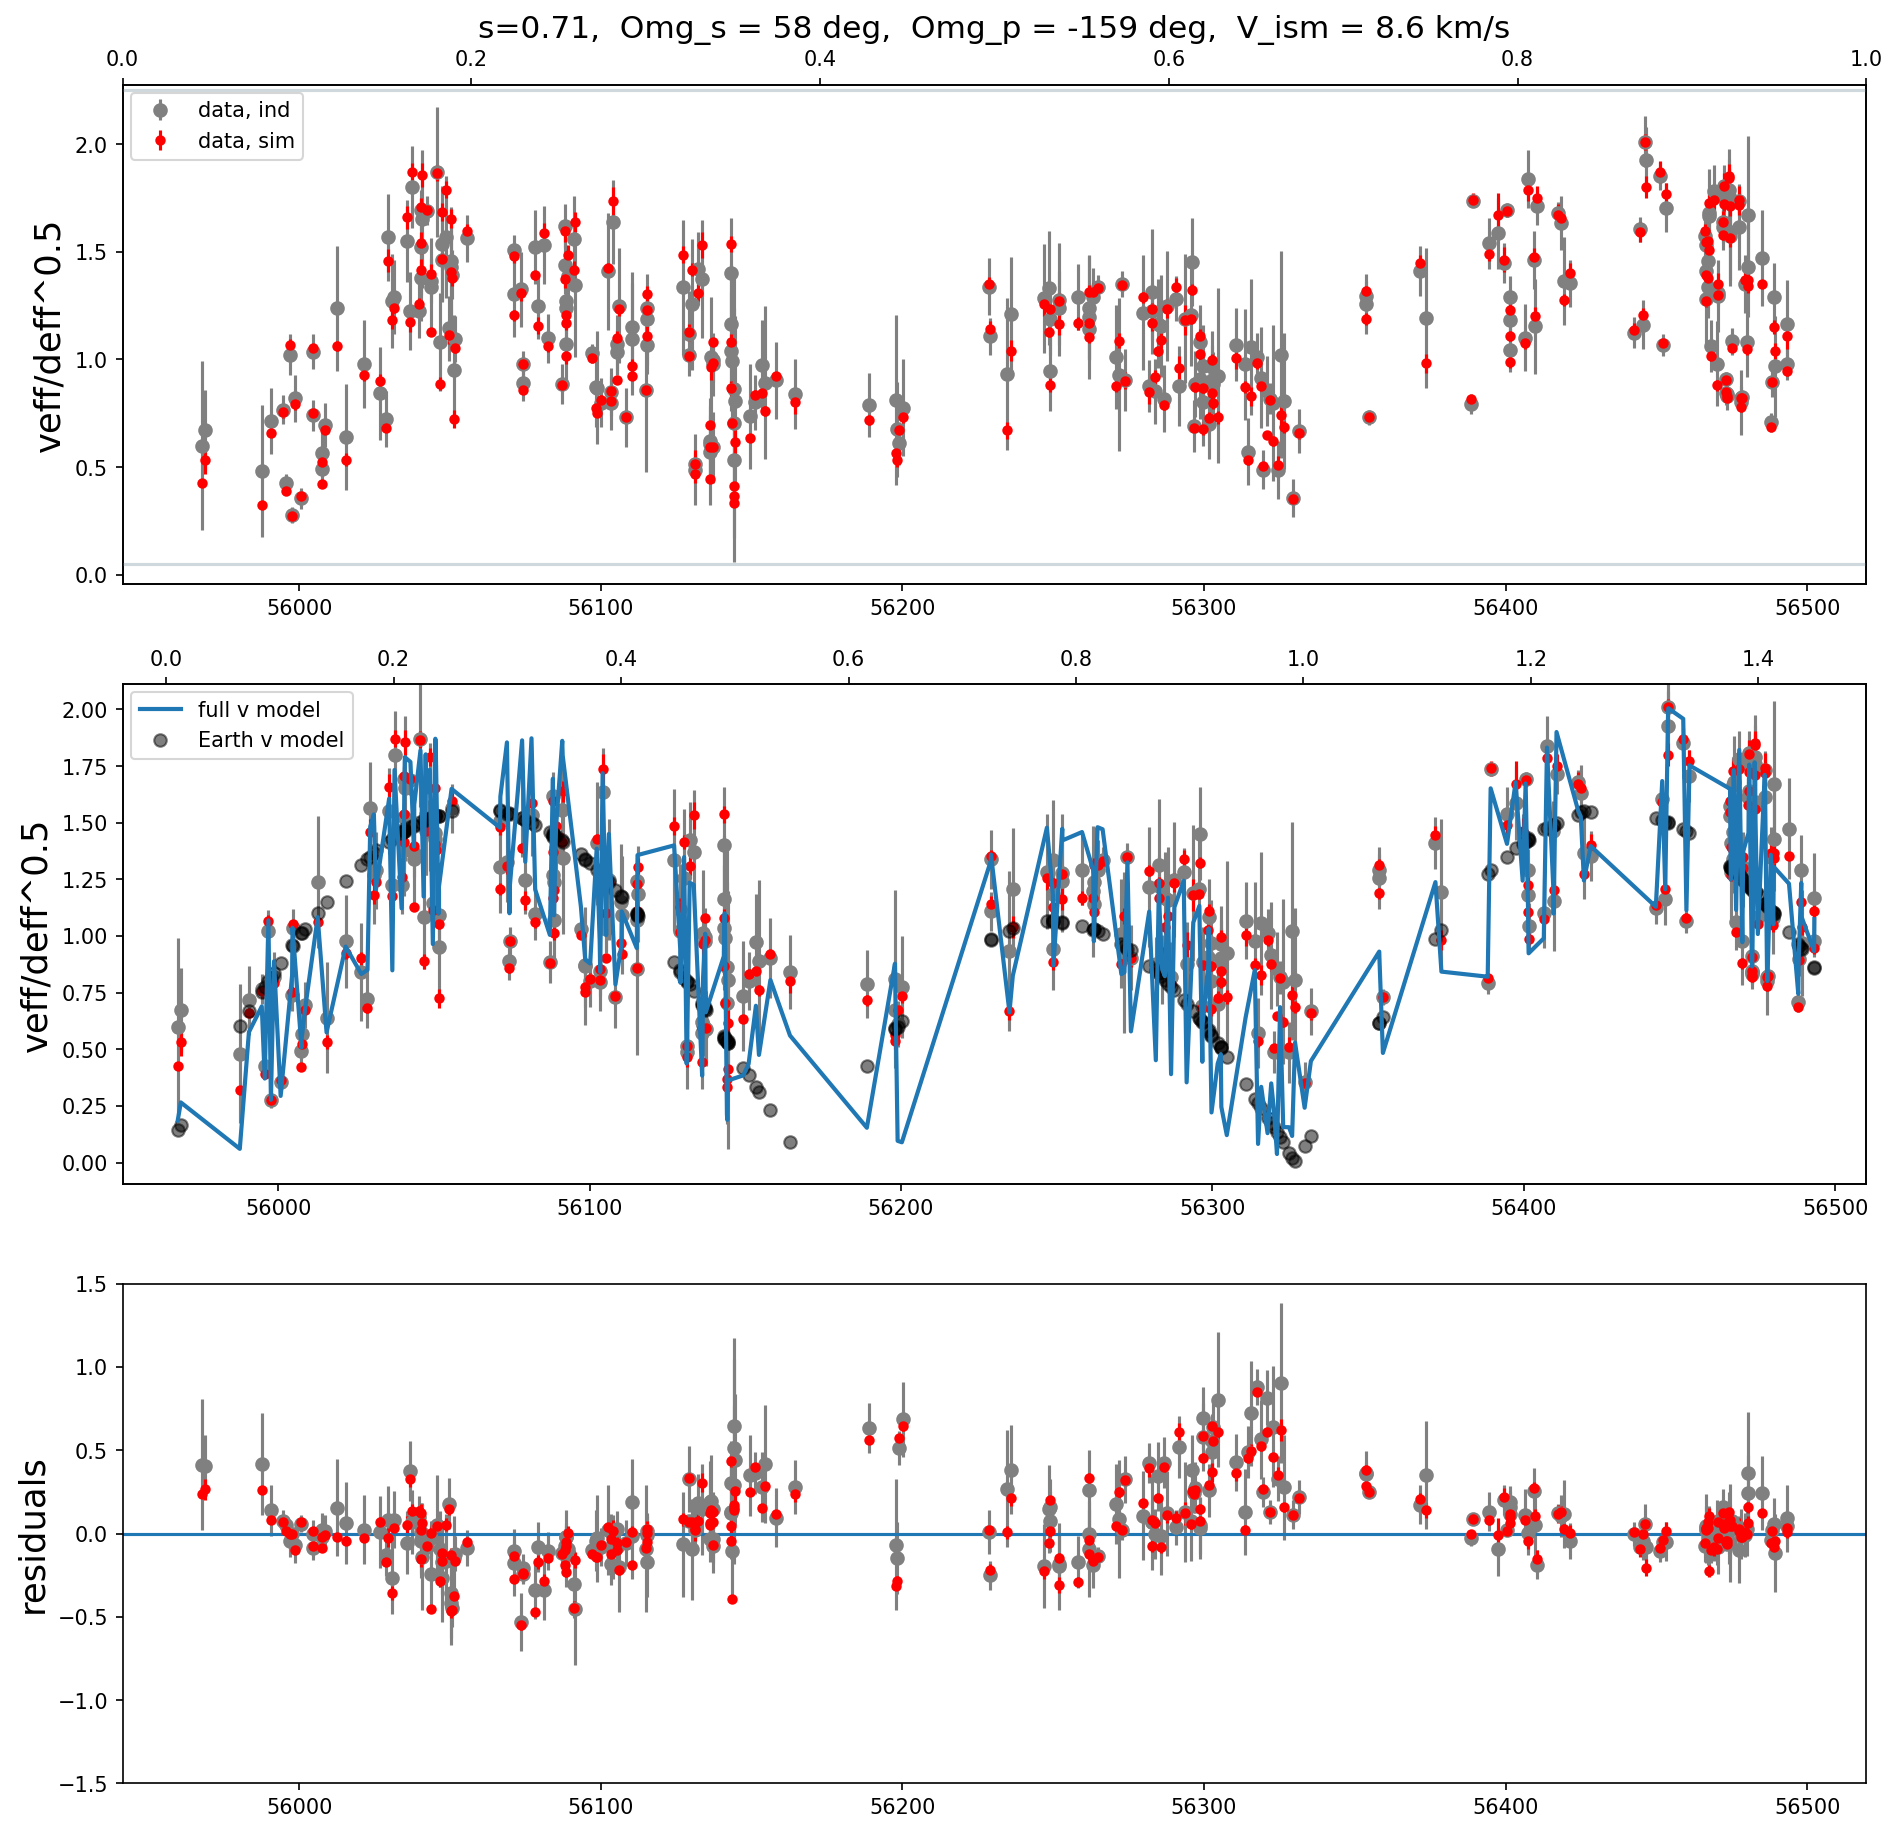

In [941]:
fig, ax1 = plt.subplots(figsize=(15,15), dpi=150)
ax1=plt.subplot(311)
ax2 = ax1.twiny()
ax1.set_title('s=0.71,  Omg_s = 58 deg,  Omg_p = -159 deg,  V_ism = 8.6 km/s', fontsize=15)
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none', label='data, ind')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4, label='data, sim')
plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)
ax1.set_ylabel('veff/deff^0.5', fontsize=17)

ax1.legend(loc=(0.005,0.85))

#fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)

ax1=plt.subplot(312)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4)

ax1.errorbar(np.array(mjds_dvs_all),np.abs(earth_motion), color='k', marker='o',
             ls='none', lw=3, alpha=0.5, label='Earth v model')
ax1.plot(t.mjd, model_abs, lw=2, zorder=3, label='full v model')
ax1.set_xlim(55950,56510)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax1.set_ylabel('veff/deff^0.5', fontsize=17)
ax1.legend(loc=(0.005,0.85))

ax1=plt.subplot(313)
residuals_all=np.array(dv_ovl_all_all)-model_abs
residuals_sim=np.array(dv_ovl_sim_all)-model_abs
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.axhline(0.0)
ax1.set_ylim(-1.5,1.5)
ax1.set_ylabel('residuals', fontsize=17)
plt.savefig('fit_try_Omg_p_free.png',format='png',bbox_inches='tight',dpi=100)

Text(0.5, 1.0, 'Residuals')

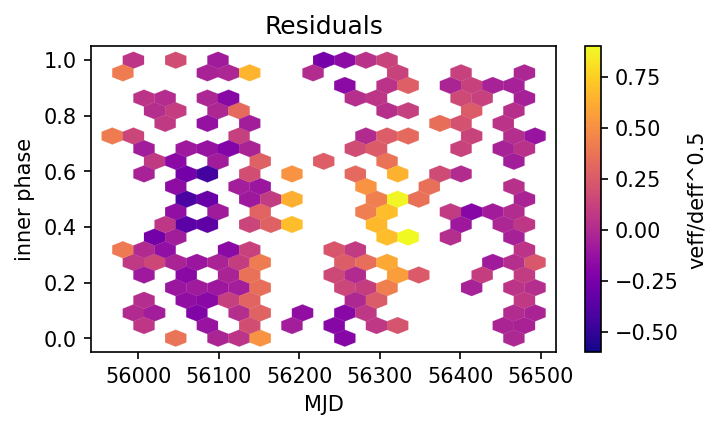

In [943]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,residuals_all, size=20,cmap='plasma', vmin=-0.6, vmax=0.9)
plt.title('Residuals')

Text(0.5, 1.0, 'Residuals')

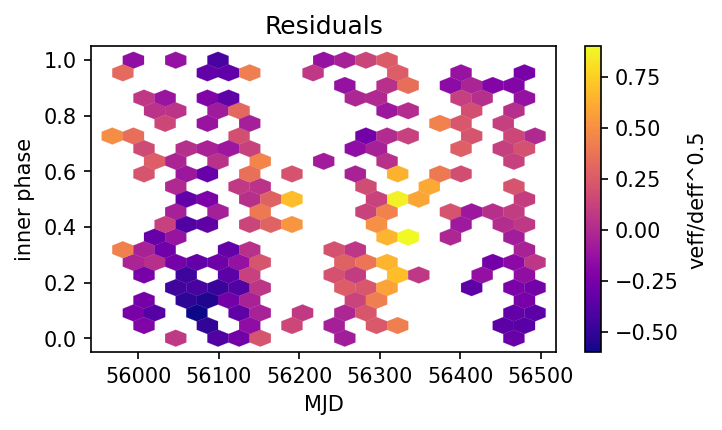

In [944]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,residuals_all_omgpfx, size=20,cmap='plasma', vmin=-0.6, vmax=0.9)
plt.title('Residuals')

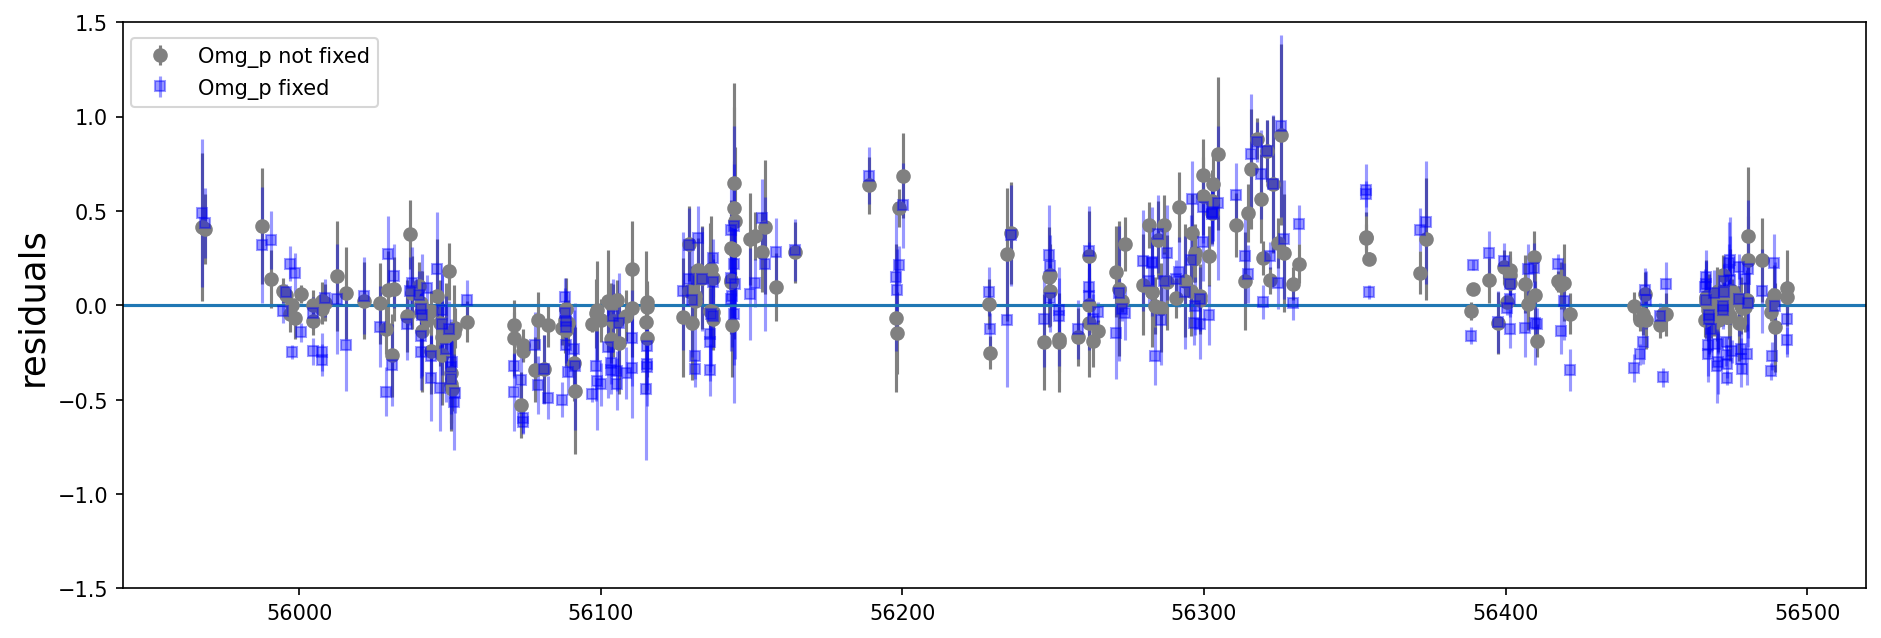

In [957]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none',
            label='Omg_p not fixed')
ax1.errorbar(np.array(mjds_dvs_all),residuals_all_omgpfx,yerr=dv_ovl_all_all_err,
             color='b', marker='s',ls='none', alpha=0.4,label='Omg_p fixed', ms=5)
#ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.set_ylim(-1.5,1.5)
ax1.set_ylabel('residuals', fontsize=17)
#ax1.set_xlim(55990,56050)
ax1.axhline(0.0)
ax1.legend(loc=(0.005,0.85))
plt.savefig('residual_difference_all.png',format='png',bbox_inches='tight',dpi=100)

In [921]:
np.sum((residuals_all_omgpfx/dv_ovl_all_all_err)**2)

1890.2769401056437

In [919]:
np.sum((residuals_all/dv_ovl_all_all_err)**2)

649.5869913129704

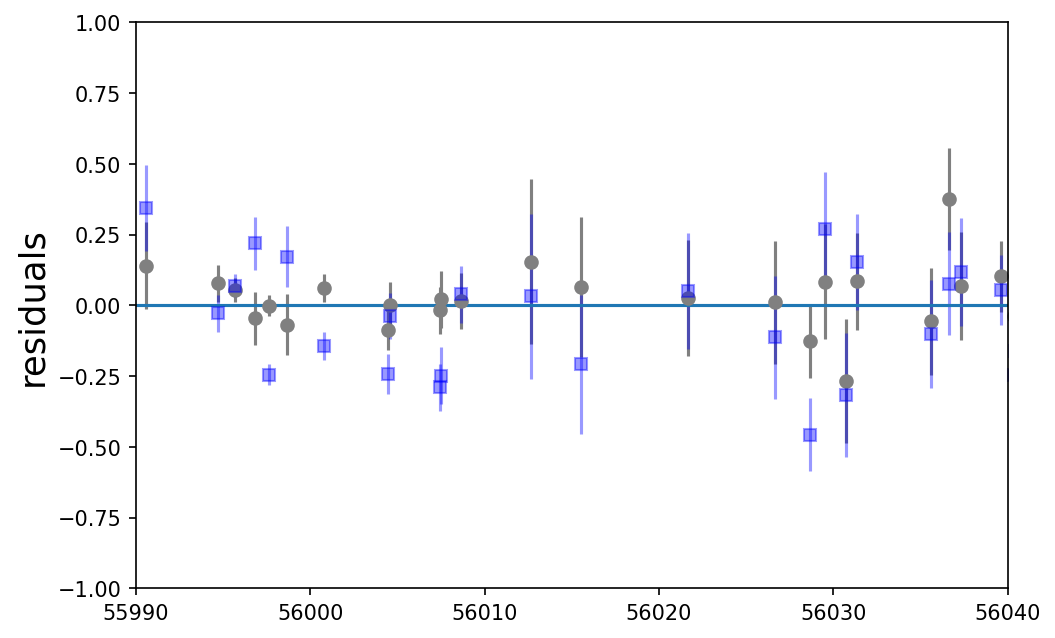

In [958]:
fig, ax1 = plt.subplots(figsize=(7.5,5), dpi=150)
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_all_omgpfx,yerr=dv_ovl_all_all_err,
             color='b', marker='s',ls='none', alpha=0.4)
#ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.set_ylim(-1,1)
ax1.set_ylabel('residuals', fontsize=17)
ax1.set_xlim(55990,56040)
ax1.axhline(0.0)
plt.savefig('residual_difference_55990-56040.png',format='png',bbox_inches='tight',dpi=100)

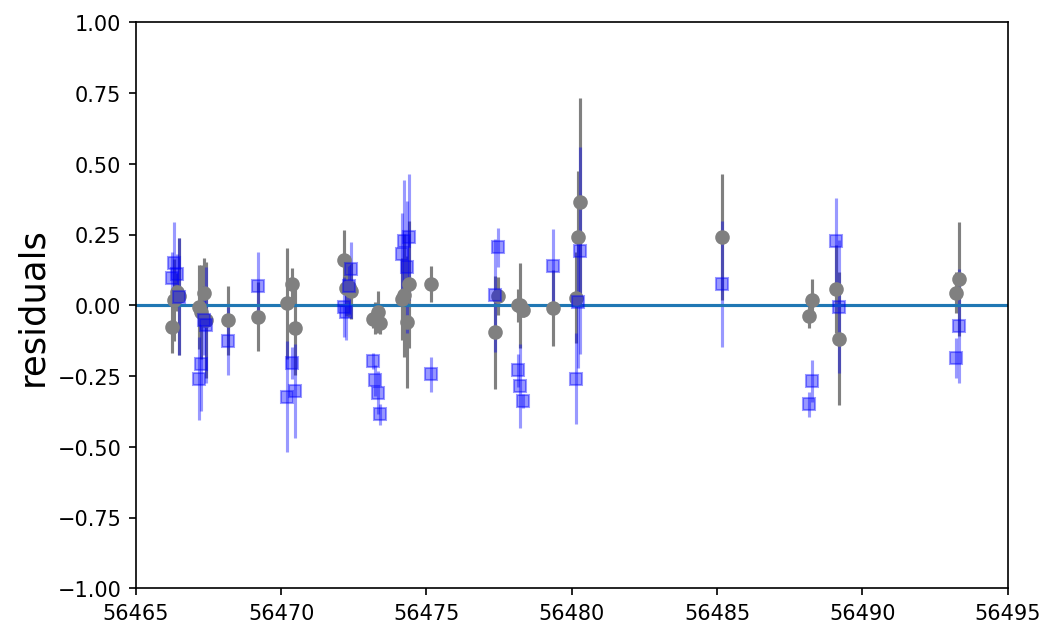

In [959]:
fig, ax1 = plt.subplots(figsize=(7.5,5), dpi=150)
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_all_omgpfx,yerr=dv_ovl_all_all_err,
             color='b', marker='s',ls='none', alpha=0.4)
ax1.set_ylim(-1,1)
ax1.set_ylabel('residuals', fontsize=17)
ax1.set_xlim(56465,56495)
ax1.axhline(0.0)
plt.savefig('residual_difference_56465-56495.png',format='png',bbox_inches='tight',dpi=100)

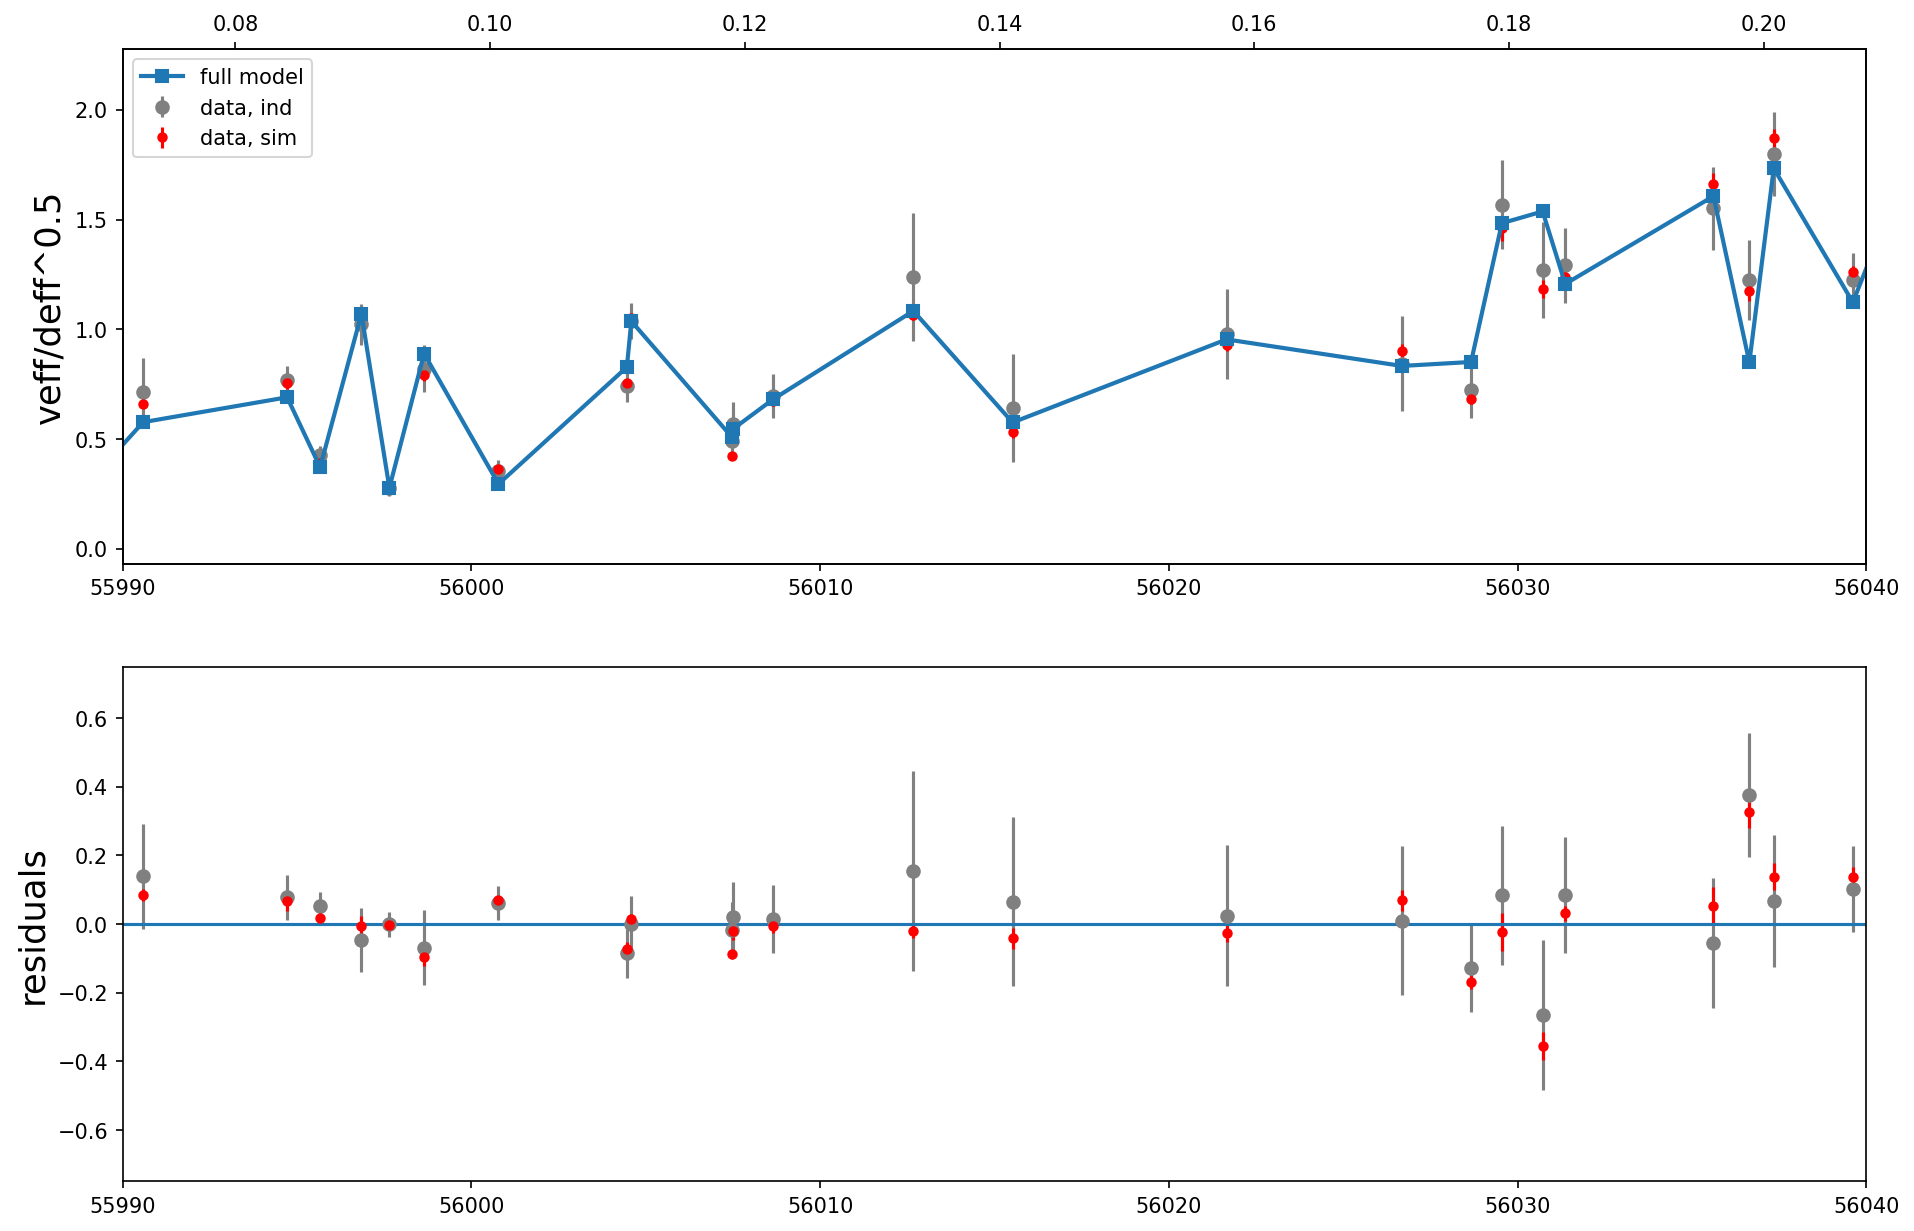

In [965]:
fig, ax1 = plt.subplots(figsize=(15,10), dpi=150)
ax1=plt.subplot(211)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none', label='data, ind')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4, label='data, sim')
ax1.plot(t.mjd, model_abs, lw=2, zorder=3, marker='s', label='full model')
ax1.set_xlim(55990,56040)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax1.set_ylabel('veff/deff^0.5', fontsize=17)
ax1.legend(loc='upper left')


ax1=plt.subplot(212)
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.set_ylim(-0.75,0.75)
ax1.set_ylabel('residuals', fontsize=17)
ax1.set_xlim(55990,56040)
ax1.axhline(0.0)
plt.savefig('fit_zoom_55990-56040_new.png',format='png',bbox_inches='tight',dpi=100)

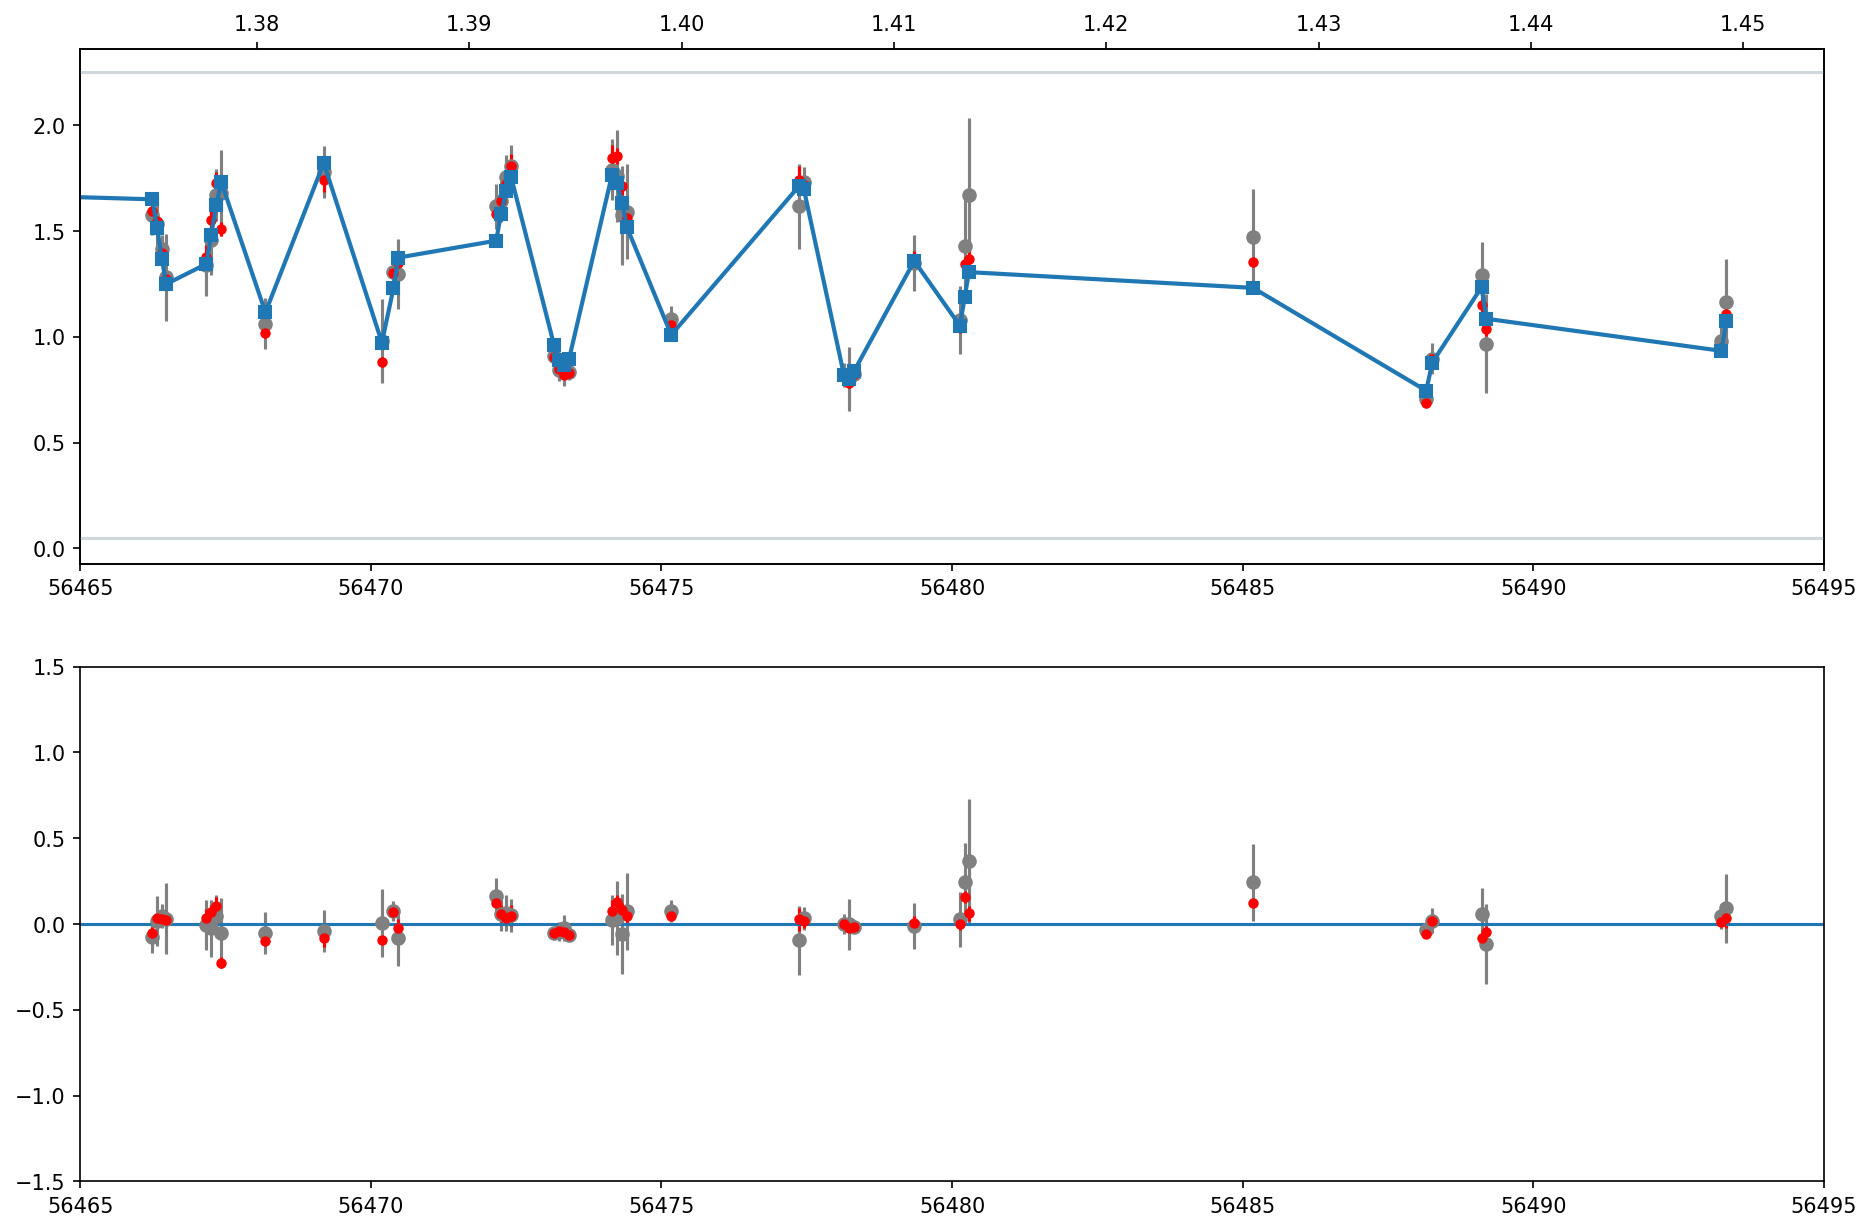

In [966]:
fig, ax1 = plt.subplots(figsize=(15,10), dpi=150)
ax1=plt.subplot(211)
ax2 = ax1.twiny()
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_all_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',
             ls='none')
ax1.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='r', marker='o',
             ls='none', ms=4)
plt.axhline(0.05, color=np.array([207, 216, 220])/255., zorder=0)
plt.axhline(2.25, color=np.array([207, 216, 220])/255., zorder=0)

ax1.plot(t.mjd, model_abs, lw=2, zorder=3, marker='s')
ax1.set_xlim(56465,56495)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
ax2.set_ylabel('veff/deff^0.5')


ax1=plt.subplot(212)
ax1.errorbar(np.array(mjds_dvs_all),residuals_all,yerr=dv_ovl_all_all_err, color='grey', marker='o',ls='none')
ax1.errorbar(np.array(mjds_dvs_all),residuals_sim,yerr=dv_ovl_sim_all_err, color='r', marker='o',ls='none', ms=4)
ax1.set_ylim(-1.5,1.5)
ax1.set_xlim(56465,56495)
ax1.axhline(0.0)
plt.savefig('fit_zoom_56465-56495_new.png',format='png',bbox_inches='tight',dpi=100)

Text(0, 0.5, 'veff/deff^0.5')

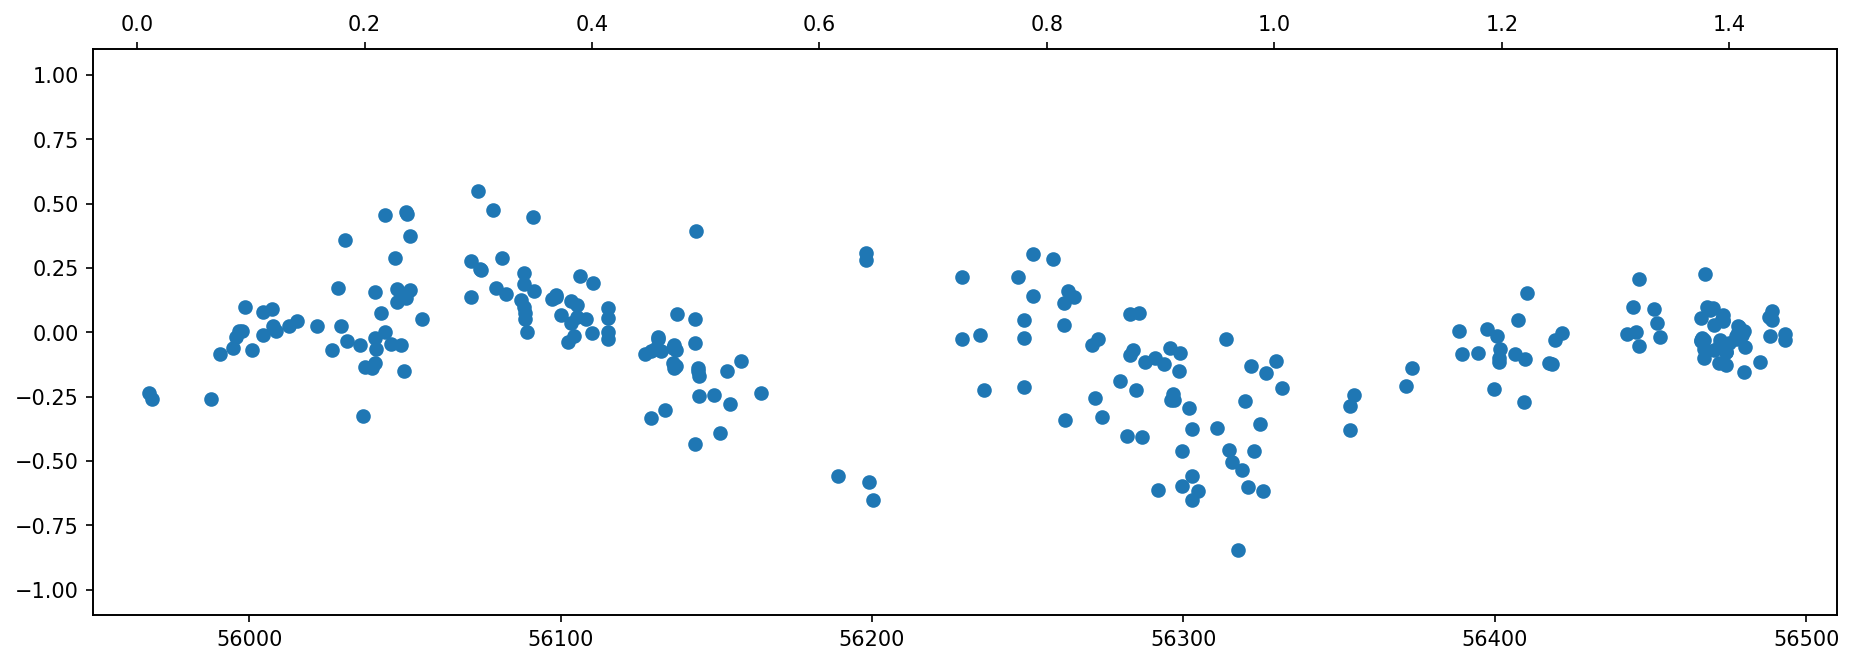

In [837]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
ax2 = ax1.twiny()
residuals=model_abs-np.array(dv_ovl_sim_all)
ax1.plot(t.mjd,residuals, zorder=3, ls='none', marker='o')
ax1.set_xlim(55950,56510)
ax1.set_ylim(-1.1,1.1)
d_n, d_x = ax1.get_xlim()
ax2.set_xlim(day_to_year(d_n)-2012.1, day_to_year(d_x)-2012.1)
plt.ylabel('veff/deff^0.5')

Text(0.5, 1.0, 'Model')

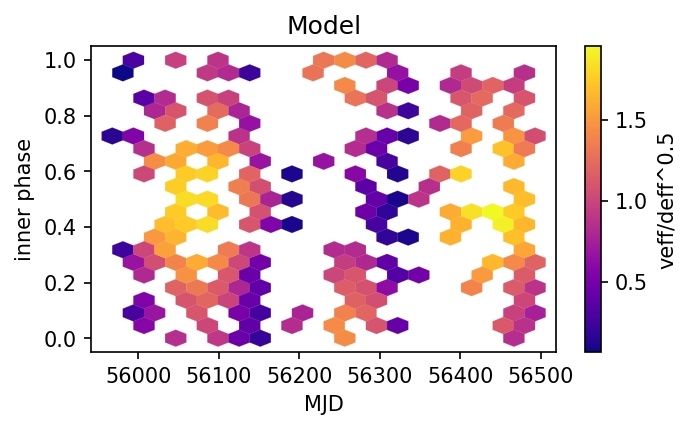

In [700]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,model_abs, size=20,cmap='plasma')
plt.title('Model')

Text(0.5, 1.0, 'Data')

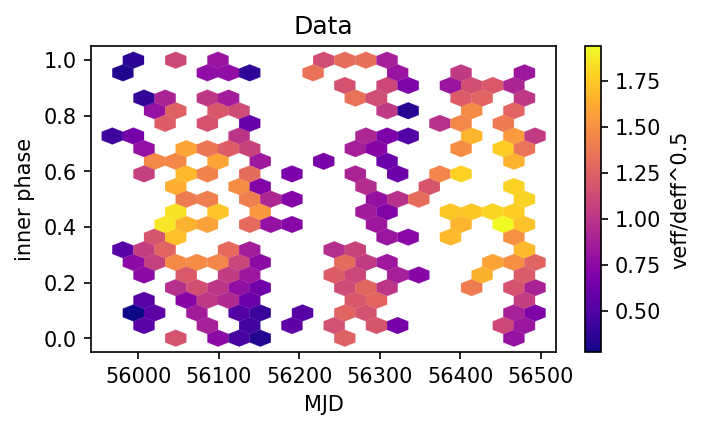

In [701]:
plt.figure(figsize=(5,2.7), dpi=150)
plot_hex(np.array(mjds_dvs_all)-0.18,np.array(dv_ovl_sim_all), size=20,cmap='plasma')
plt.title('Data')

# Explore dependance on Omg_s:

0.7809648619984819 km / (pc(1/2) s)
0.31396027630358025 km / (pc(1/2) s)
-0.12012802925373295 km / (pc(1/2) s)
-0.31818531214905693 km / (pc(1/2) s)
-0.1875383685541564 km / (pc(1/2) s)
0.21068164464387182 km / (pc(1/2) s)
0.6901431575472023 km / (pc(1/2) s)
1.0265007996472035 km / (pc(1/2) s)
1.0623690920064888 km / (pc(1/2) s)
0.7809648619984819 km / (pc(1/2) s)


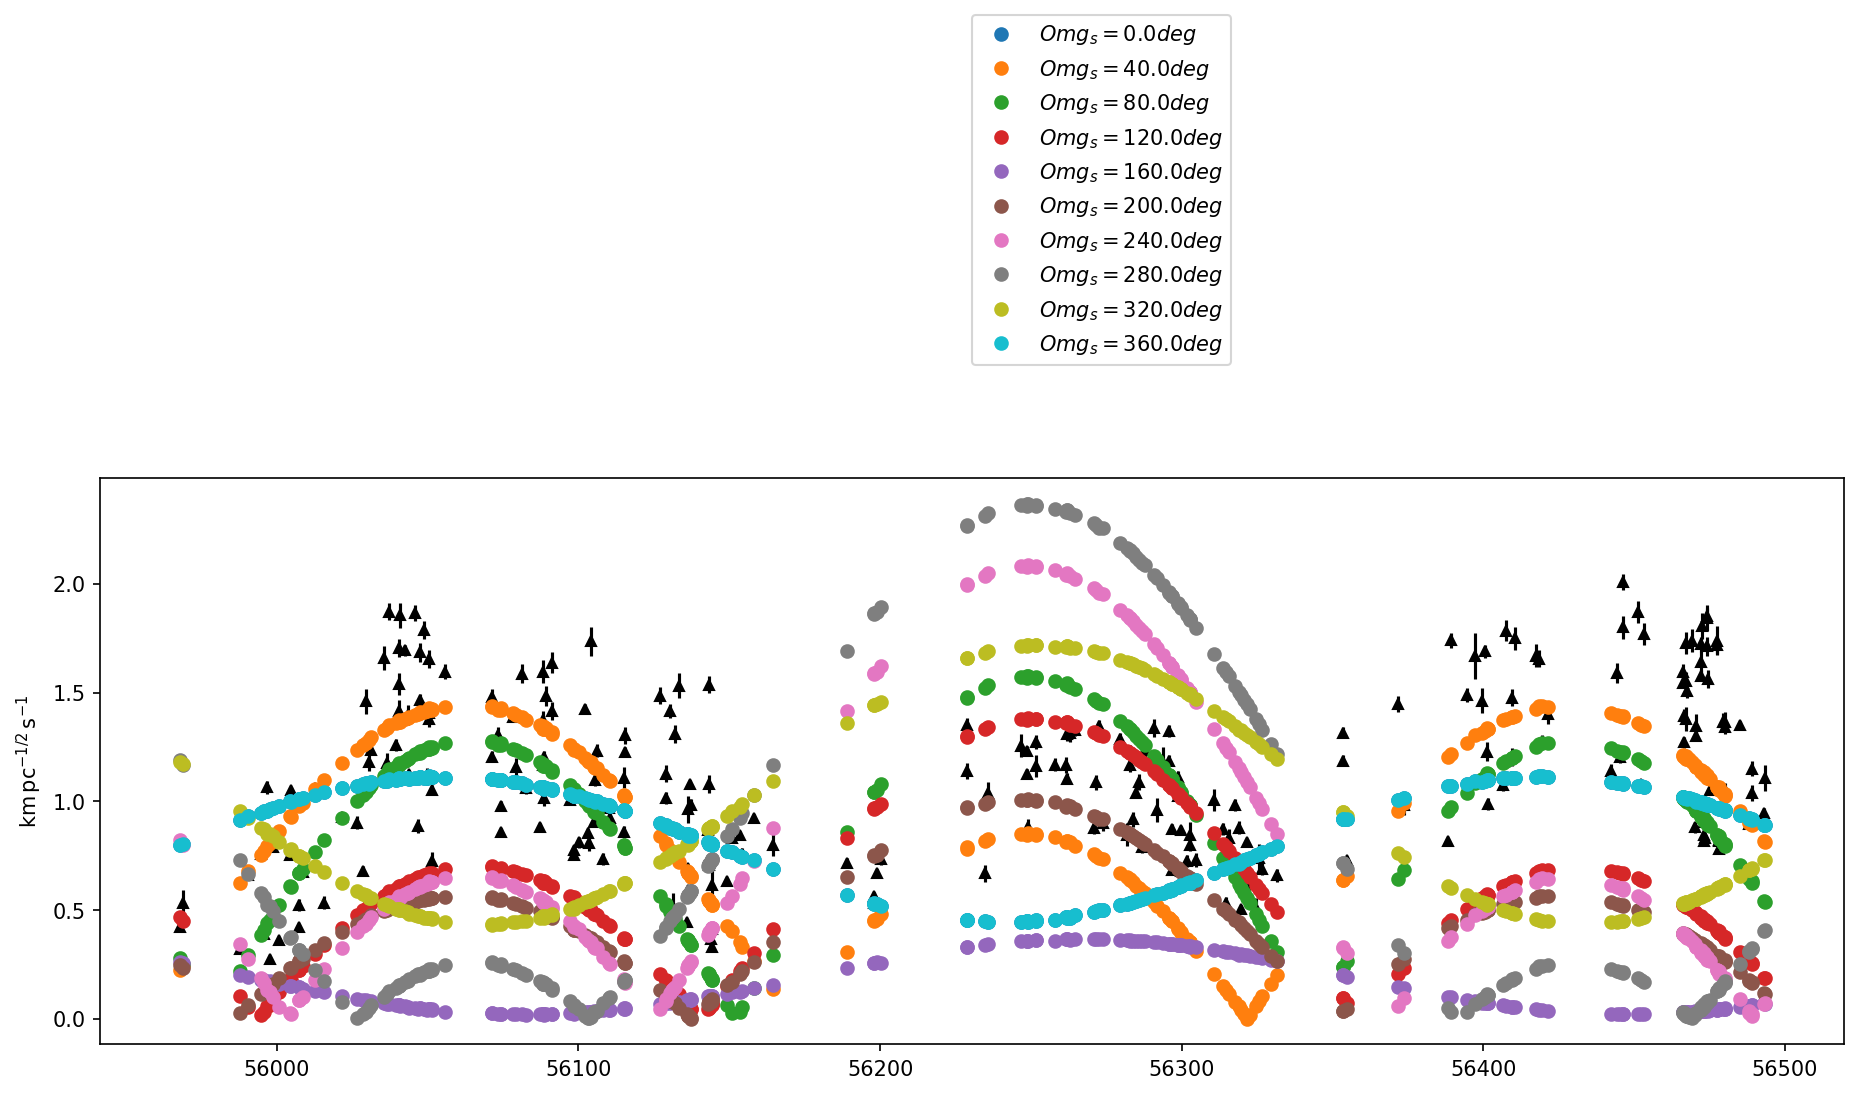

In [746]:
s=0.75
ds=(1-s)*dp
D_eff=dp*ds/(dp-ds)
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
for i in range(0,10):

    Omg_s=40*i*u.deg#+4*i*u.deg

    Omg_p=-44*u.deg# from Voisin et al. 2020
    dOmg_p=Omg_s-Omg_p

    bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
    bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

    bse = np.sin(Omg_s) / (D_eff**0.5)
    bce = np.cos(Omg_s) / (D_eff**0.5)

    v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
    v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

    V_ism=6*u.km/u.s

    dveff_c = (V_ism/s - (v_pm_ra*np.sin(Omg_s) + v_pm_dec*np.cos(Omg_s)))/D_eff**0.5
    #dveff_c = - 0.4*u.km/u.s/u.pc**0.5

    print (dveff_c)

    t=Time(np.array(mjds_dvs_all), format='mjd')

    #t=np.arange(mjds_dvs_all[0],mjds_dvs_all[-1], 0.25)
    #t=Time(t, format='mjd')


    Kp_i=orb_mean_vel(asini_i, PB_i)
    Kp_o=orb_mean_vel(asini_o, PB_o)

    ph_i=phase_orbit(t, T_asc0_i, PB_i)
    ph_o=phase_orbit(t, T_asc0_o, PB_o)

    #Ve=earth_vel(t, psr_frame, wsrt_loc)
    #Ve_ra=Ve[1]
    #Ve_dec=Ve[2]


    dveff_model = (bsp * (Kp_i * np.sin(ph_i) + Kp_o * np.sin(ph_o))
                 + bcp * (Kp_i * np.cos(ph_i) + Kp_o * np.cos(ph_o))
                 - Ve_ra * bse - Ve_dec * bce + dveff_c)
    
    earth_motion=- Ve_ra * bse - Ve_dec * bce + dveff_c
    
    plt.plot(t.mjd, np.abs(earth_motion), marker='o', ls='none', label=r'$Omg_s = %.1f deg$'%Omg_s.value)
    
plt.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='k', marker='^',
             ls='none', ms=5, zorder=0)
plt.legend(loc=(0.5,1.2))
plt.show()

-0.67462496241017 km / (pc(1/2) s)
-0.41841991632203057 km / (pc(1/2) s)
-0.1622148702338911 km / (pc(1/2) s)
0.09399017585424835 km / (pc(1/2) s)
0.3501952219423877 km / (pc(1/2) s)
0.6064002680305273 km / (pc(1/2) s)
0.8626053141186667 km / (pc(1/2) s)
1.1188103602068062 km / (pc(1/2) s)
1.3750154062949453 km / (pc(1/2) s)
1.6312204523830849 km / (pc(1/2) s)


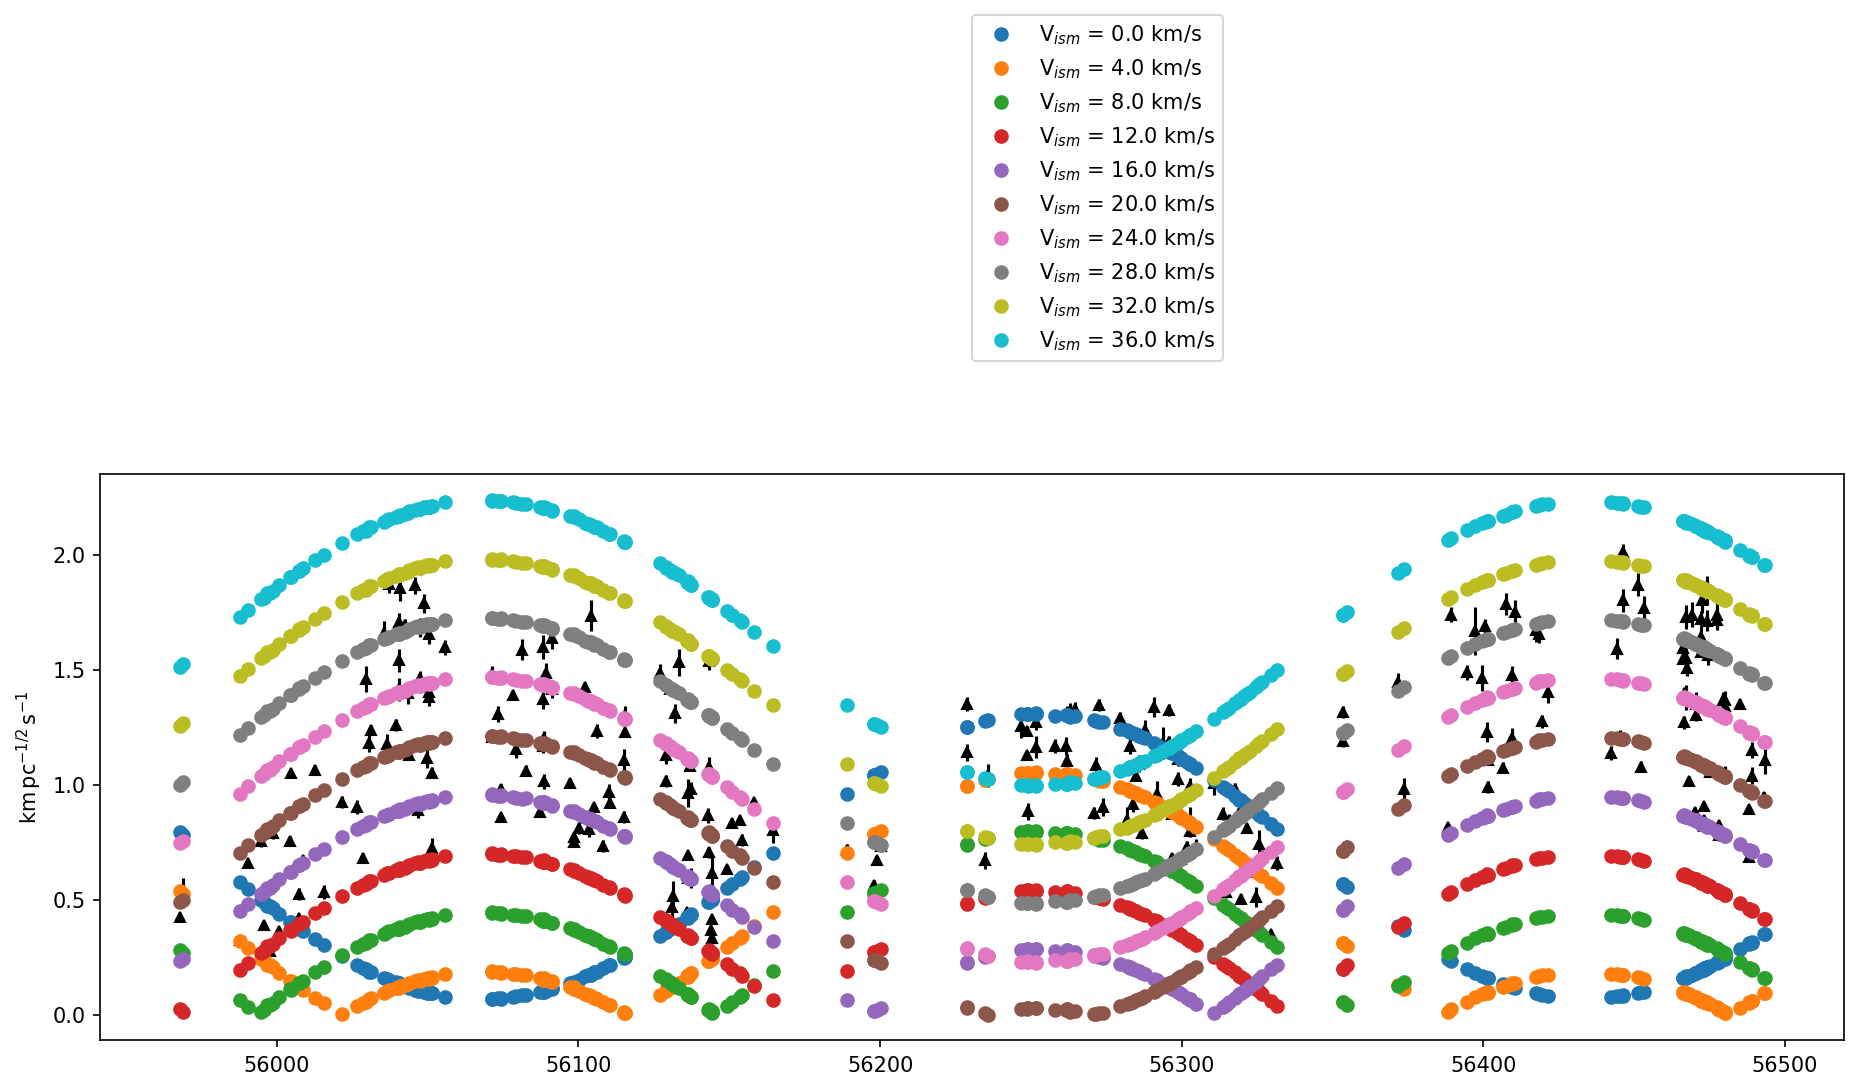

In [787]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
for i in range(0,10):
    s=0.75
    ds=(1-s)*dp
    D_eff=dp*ds/(dp-ds)
    
    Omg_s=141*u.deg

    Omg_p=-44*u.deg# from Voisin et al. 2020
    dOmg_p=Omg_s-Omg_p

    bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
    bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

    bse = np.sin(Omg_s) / (D_eff**0.5)
    bce = np.cos(Omg_s) / (D_eff**0.5)

    v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
    v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

    V_ism=i*4*u.km/u.s

    dveff_c = (V_ism/s - (v_pm_ra*np.sin(Omg_s) + v_pm_dec*np.cos(Omg_s)))/D_eff**0.5
    #dveff_c = - 0.4*u.km/u.s/u.pc**0.5

    print (dveff_c)

    t=Time(np.array(mjds_dvs_all), format='mjd')

    #t=np.arange(mjds_dvs_all[0],mjds_dvs_all[-1], 0.25)
    #t=Time(t, format='mjd')


    Kp_i=orb_mean_vel(asini_i, PB_i)
    Kp_o=orb_mean_vel(asini_o, PB_o)

    ph_i=phase_orbit(t, T_asc0_i, PB_i)
    ph_o=phase_orbit(t, T_asc0_o, PB_o)

    #Ve=earth_vel(t, psr_frame, wsrt_loc)
    #Ve_ra=Ve[1]
    #Ve_dec=Ve[2]


    dveff_model = (bsp * (Kp_i * np.sin(ph_i) + Kp_o * np.sin(ph_o))
                 + bcp * (Kp_i * np.cos(ph_i) + Kp_o * np.cos(ph_o))
                 - Ve_ra * bse - Ve_dec * bce + dveff_c)
    
    earth_motion=- Ve_ra * bse - Ve_dec * bce + dveff_c
    
    plt.plot(t.mjd, np.abs(earth_motion), marker='o', ls='none', label=r'V$_{ism}$ = %.1f km/s'%V_ism.value)
    
plt.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='k', marker='^',
             ls='none', ms=5, zorder=0)
plt.legend(loc=(0.5,1.2))
plt.show()

-1.0390159508355965 km / (pc(1/2) s)
-0.9007231870683224 km / (pc(1/2) s)
-0.7743929452232708 km / (pc(1/2) s)
-0.6558652005703636 km / (pc(1/2) s)
-0.5417070293377848 km / (pc(1/2) s)
-0.4286929543882882 km / (pc(1/2) s)
-0.3132863737067587 km / (pc(1/2) s)
-0.1908909292950631 km / (pc(1/2) s)
-0.05437635487649784 km / (pc(1/2) s)
0.109661851410764 km / (pc(1/2) s)


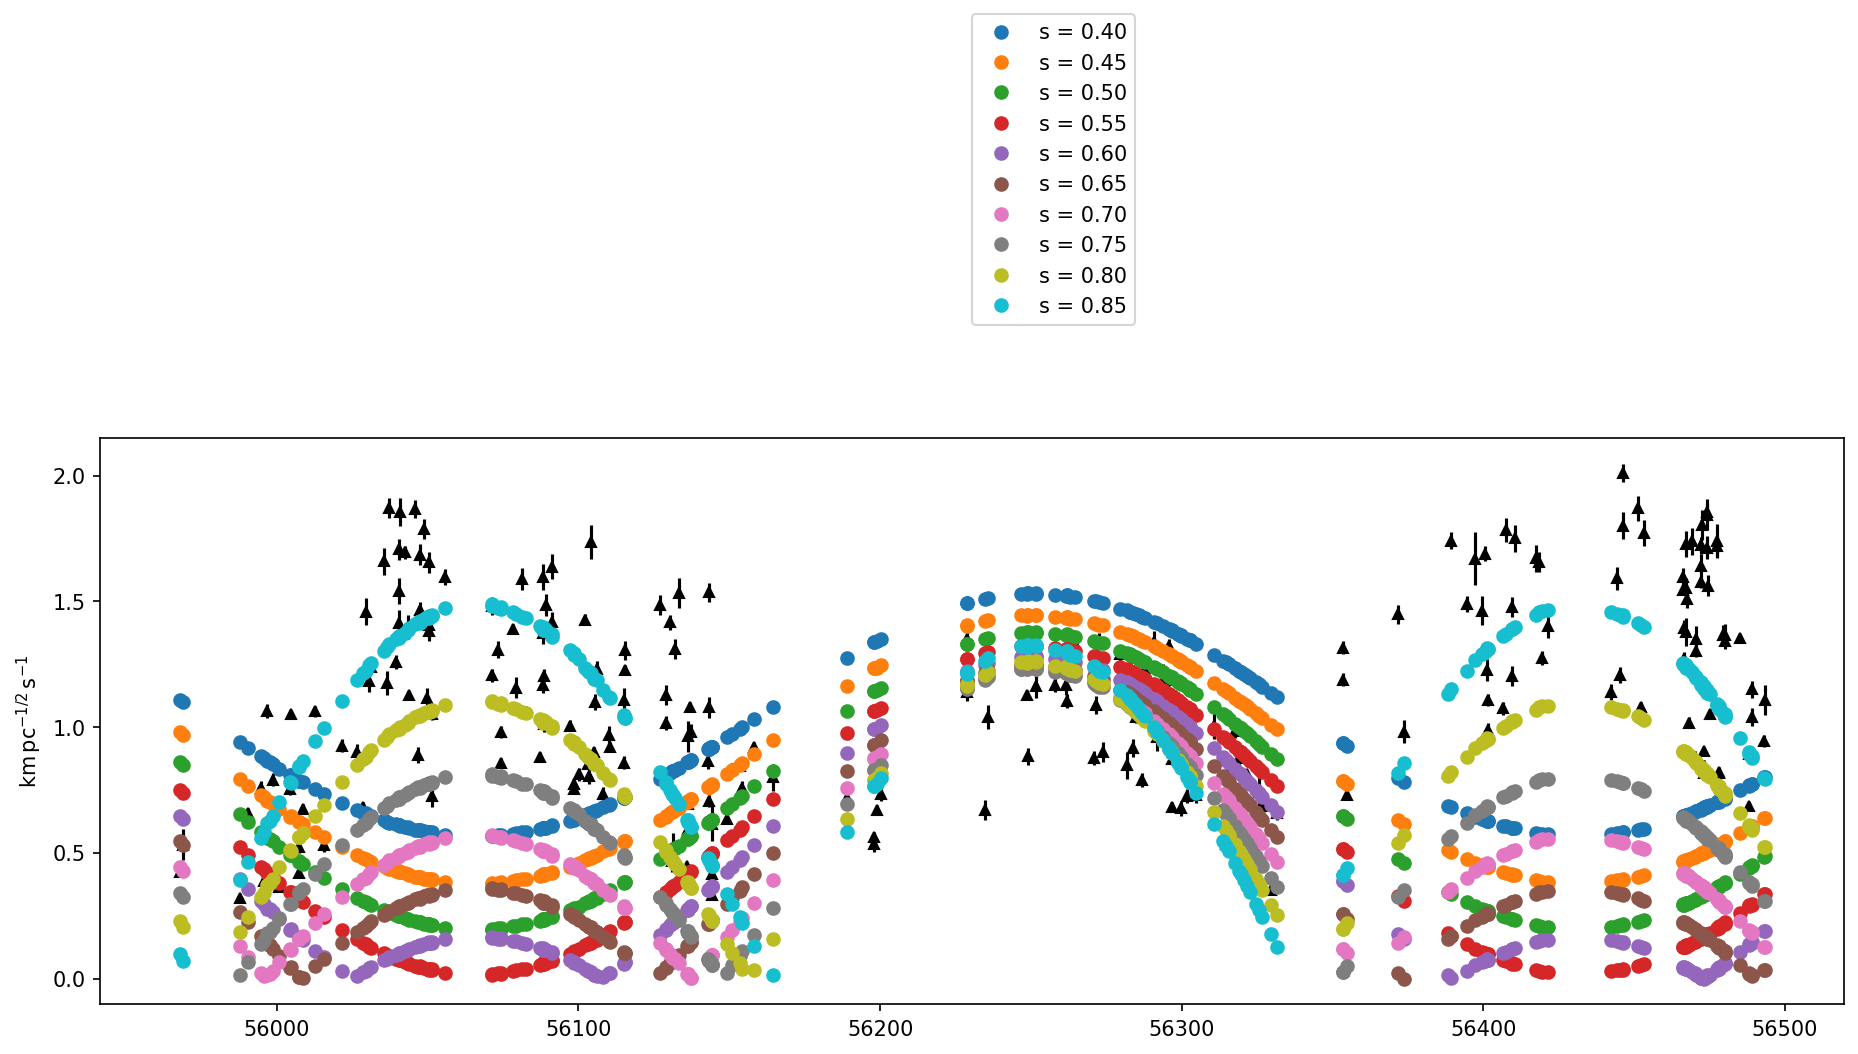

In [792]:
fig, ax1 = plt.subplots(figsize=(15,5), dpi=150)
for i in range(0,10):
    s=0.4+0.05*i
    ds=(1-s)*dp
    D_eff=dp*ds/(dp-ds)
    
    Omg_s=(121)*u.deg

    Omg_p=-44*u.deg# from Voisin et al. 2020
    dOmg_p=Omg_s-Omg_p

    bsp =   (np.cos(dOmg_p) * D_eff**0.5) / (dp * np.sin(i_ang))
    bcp = - (np.sin(dOmg_p) * D_eff**0.5) / (dp * np.tan(i_ang))

    bse = np.sin(Omg_s) / (D_eff**0.5)
    bce = np.cos(Omg_s) / (D_eff**0.5)

    v_pm_ra  = mu_to_vel(psr.pm_ra_cosdec, D_eff)
    v_pm_dec = mu_to_vel(psr.pm_dec, D_eff)

    V_ism=8*u.km/u.s

    dveff_c = (V_ism/s - (v_pm_ra*np.sin(Omg_s) + v_pm_dec*np.cos(Omg_s)))/D_eff**0.5
    #dveff_c = - 0.4*u.km/u.s/u.pc**0.5

    print (dveff_c)

    t=Time(np.array(mjds_dvs_all), format='mjd')

    #t=np.arange(mjds_dvs_all[0],mjds_dvs_all[-1], 0.25)
    #t=Time(t, format='mjd')


    Kp_i=orb_mean_vel(asini_i, PB_i)
    Kp_o=orb_mean_vel(asini_o, PB_o)

    ph_i=phase_orbit(t, T_asc0_i, PB_i)
    ph_o=phase_orbit(t, T_asc0_o, PB_o)

    #Ve=earth_vel(t, psr_frame, wsrt_loc)
    #Ve_ra=Ve[1]
    #Ve_dec=Ve[2]


    dveff_model = (bsp * (Kp_i * np.sin(ph_i) + Kp_o * np.sin(ph_o))
                 + bcp * (Kp_i * np.cos(ph_i) + Kp_o * np.cos(ph_o))
                 - Ve_ra * bse - Ve_dec * bce + dveff_c)
    
    earth_motion=- Ve_ra * bse - Ve_dec * bce + dveff_c
    
    plt.plot(t.mjd, np.abs(earth_motion), marker='o', ls='none', label=r's = %.2f'%s)
    
plt.errorbar(np.array(mjds_dvs_all),dv_ovl_sim_all,yerr=dv_ovl_sim_all_err, color='k', marker='^',
             ls='none', ms=5, zorder=0)
plt.legend(loc=(0.5,1.2))
plt.show()